# Exploratory Data Analysis
Exploratory data analysis for the [UCI dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks.

Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days. The goal is to determine the **early readmission of the patient within 30 days of discharge**.

The problem is important for the following reasons. Despite high-quality evidence showing improved clinical outcomes for diabetic patients who receive various preventive and therapeutic interventions, many patients do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control. Failure to provide proper diabetes care not only increases the managing costs for the hospitals (as the patients are readmitted) but also impacts the morbidity and mortality of the patients, who may face complications associated with diabetes.

## **0. Initial Setup**
Taking care of package imports, defining work constants, and loading all necessary datasets.

### 0.1 Python imports

In [470]:
# Data Analysis
import numpy as np
import pandas as pd
import scipy as sp

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Miscellaneous
import math

# Visualization configurations
pd.set_option('display.max_columns', 60)
plt.style.use('ggplot')
sns.set_style('white')

In [471]:
from collections import Counter

from scipy.stats import chi2_contingency, entropy, f_oneway, pointbiserialr, zscore
from scipy.stats.contingency import association

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

### 0.2 Constants

In [472]:
DATA_PATH = '../data/original/'
DATA_PATH_PROCESSED = '../data/processed/'

RANDOM_STATE = 38

### 0.3 Loading datasets

In [473]:
diabetic_data = pd.read_csv(
    DATA_PATH + 'diabetic_data.csv',
    na_values='?',
    keep_default_na=False
)

/tmp/ipykernel_12113/651324338.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  diabetic_data = pd.read_csv(


## **1. Data Understanding**
Exploring the dataset structure from afar.

### 1.1 Dataset structure
Having an overall look at the structure of the dataset.

In [474]:
diabetic_data.sample(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
74198,220792098,48678714,Caucasian,Male,[60-70),NaN,1,1,7,2,MC,Emergency/Trauma,1,0,21,1,0,0,491,403,250.4,6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30
23764,81102966,60764067,Caucasian,Male,[40-50),[100-125),1,1,7,4,NaN,NaN,35,1,11,1,0,0,824,E885,250,7,None,None,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
60348,169151706,25369767,Caucasian,Male,[80-90),NaN,3,11,1,4,CP,Cardiology,46,6,36,0,0,0,414,518,411,5,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
73847,219143508,81431550,Caucasian,Male,[80-90),NaN,1,1,7,6,NaN,InternalMedicine,77,0,20,0,0,0,434,486,427,9,None,>7,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
36708,112947942,25776972,Caucasian,Male,[60-70),[150-175),3,1,1,2,UN,Cardiology,59,4,15,4,0,1,427,424,402,9,None,None,No,No,No,No,No,No,No,Steady,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,NO


**Feature data types**
- Most features are <u>categorical</u>: demographic, patient characteristics, test results, and medications.
- Some features are <u>numerical</u>: hospital administration related (codes), and patient history related.

In [475]:
diabetic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

**Missing values**
- Weight and payer_code are missing respectively 97% and 40% of values, these can simply be thrown out.
- Medical specialty is also missing 50% of values, but it might be important, and there's a change they can be imputed.
- Very few values for diagnoses and race are missing.

In [476]:
total = diabetic_data.isnull().sum().sort_values(ascending=False)
percent = (diabetic_data.isnull().sum() / diabetic_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
weight,98569,0.968585
medical_specialty,49949,0.490822
payer_code,40256,0.395574
race,2273,0.022336
diag_3,1423,0.013983
diag_2,358,0.003518
diag_1,21,0.000206
admission_type_id,0,0.000000
patient_nbr,0,0.000000
encounter_id,0,0.000000


### 1.2 Feature Distribution
Having an overall look at the distribution of features.

**Distribution of numerical features**
- The encounter and patient identifiers are not useful, will simply be removed.
- The {something}_id features are not actually numerical, but categorical. Those need to be converted to their string representation.
- Almost all other numerical features present outliers way beyond 3-4 Z-scores. 

In [477]:
diabetic_data.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


**Distribution of categorical features**
- Many features (race, gender, age...) have less than 10 values, they can mostly be left as is.
- A few values (change, diabetesMed) are binary, which makes them very easy to handle.
- Some features (medical_specialty, diagnoses) are a huge amount of values, they will require binning somehow.

In [478]:
diabetic_data.describe(include=['O'])

,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,99493,101766,101766,3197,61510,51817,101745,101408,100343,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,5,3,10,9,17,72,716,748,789,4,4,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,1,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,[70-80),[75-100),MC,InternalMedicine,428,276,250,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54708,26068,1336,32439,14635,6862,6752,11555,96420,84748,81778,100227,101063,101680,96575,101765,89080,91116,101743,94438,95401,101458,101728,101763,101727,101766,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


## **2. Data Visualization (pre)**
Having an initial look at the relationships between features, before preprocessing.

### 2.0 Functions
General-purpose functions for visual analysis.

#### 2.0.1 Correlation/association measures

In [479]:
def phi_values(data: pd.DataFrame, binary_cols: list[str]):
    pb = pd.DataFrame(index=binary_cols, columns=binary_cols)
    
    for bin_col_1 in binary_cols:
        for bin_col_2 in binary_cols:    
            contingency_table = pd.crosstab(data[bin_col_2], data[bin_col_1])
            chi2, _, _, _ = chi2_contingency(contingency_table)
            n = contingency_table.values.sum()
            phi = np.sqrt(chi2 / n)
            
            pb.loc[bin_col_2, bin_col_1] = phi
    
    return pb.astype(float)

In [480]:
def point_biserial_values(data: pd.DataFrame, binary_cols: list[str], numerical_cols: list[str]):
    pb = pd.DataFrame(index=binary_cols, columns=numerical_cols)
    
    for num_col in numerical_cols:
        for binary_col in binary_cols:
            tmp = data[[binary_col, num_col]].dropna(axis=0)
            
            corr, _ = pointbiserialr(
                x=tmp[binary_col].astype(float),
                y=tmp[num_col]
            )
            pb.loc[binary_col, num_col] = corr
    
    return pb.astype(float)

In [481]:
def anova_values(data: pd.DataFrame, categorical_cols: list[str], numerical_cols: list[str]):
    anova = pd.DataFrame(index=categorical_cols, columns=numerical_cols)

    for num_col in numerical_cols:
        for cat_col in categorical_cols:
            # Get the unique category values
            categories = data[cat_col].unique()
            
            # Group the numerical values by the categories
            groups = [data[data[cat_col] == category][num_col] for category in categories]
            
            # Perform ANOVA
            f_val, _ = f_oneway(*groups)
            
            # Store the results
            anova.loc[cat_col, num_col] = f_val
    
    return anova.astype(float)

In [482]:
def cramer_values(data: pd.DataFrame, columns: list[str]):
    cramer_v = pd.DataFrame(index=columns, columns=columns)

    for col1 in columns:
        for col2 in columns:
            contingency_table = pd.crosstab(data[col1], data[col2])
            stat = association(contingency_table, method='cramer')
            cramer_v.loc[col1, col2] = stat
    
    return cramer_v.astype(float)

In [483]:
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy


def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x


def theil_values(data: pd.DataFrame, columns: list[str]):
    theil = pd.DataFrame(index=columns, columns=columns)

    for col1 in columns:
        for col2 in columns:
            stat = theil_u(
                x=data[col1],
                y=data[col2]
            )
            theil.loc[col1, col2] = stat
    
    return theil.astype(float)

#### 2.0.2 Graphs

In [484]:
def heatmap_crosstab(
        data: pd.DataFrame,
        x: str, y: str,
        rows: pd.Index | None = None,
        columns: pd.Index | None = None
):
    """
    Counts occurrences of each combination of categories between two variables,
    then visualize it using a heatmap.
    """
    # Create the crosstab with the specific column order
    crosstab = pd.crosstab(data[y], data[x])
    crosstab = crosstab.reindex(index=rows, columns=columns)

    # Normalize the crosstab to get column-wise percentages
    crosstab_percent = crosstab.div(crosstab.sum(axis=0), axis=1) * 100

    # Create an annotation matrix combining counts and percentages
    annotations = np.empty(crosstab.shape, dtype=object)
    for i in range(crosstab.shape[0]):
        for j in range(crosstab.shape[1]):
            count = crosstab.iloc[i, j]
            percent = crosstab_percent.iloc[i, j]

            if pd.isna(count) or pd.isna(percent):
                annotations[i, j] = 'N/A'
            else:
                annotations[i, j] = f'{count}\n({percent:.2f}%)' 

    # Plot the heatmap
    return sns.heatmap(
        crosstab_percent,
        annot=annotations,
        cmap="YlGnBu",
        fmt=''
    )

In [485]:
def phi_matrix(data: pd.DataFrame, binary_cols: list[str], **kwargs):
    pb = phi_values(data, binary_cols)
    
    return sns.heatmap(
        pb,
        annot=True,
        **kwargs
    )


def point_biserial_matrix(data: pd.DataFrame, binary_cols: list[str], numerical_cols: list[str], **kwargs):
    pb = point_biserial_values(data, binary_cols, numerical_cols)
    
    return sns.heatmap(
        pb,
        annot=True,
        **kwargs
    )


def anova_matrix(data: pd.DataFrame, categorical_cols: list[str], numerical_cols: list[str], **kwargs):
    anova = anova_values(data, categorical_cols, numerical_cols)
    
    return sns.heatmap(
        anova,
        annot=True,
        **kwargs
    )


def cramer_matrix(data: pd.DataFrame, columns: list[str], **kwargs):
    cramer_v = cramer_values(data, columns)
    
    return sns.heatmap(
        cramer_v,
        annot=True,
        **kwargs
    )


def theil_matrix(data: pd.DataFrame, columns: list[str], **kwargs):
    theil = theil_values(data, columns)
    
    return sns.heatmap(
        theil,
        annot=True,
        **kwargs
    )

### 2.1 Correlation / Association
Exploring the numeric correlation or association between different features.

In [486]:
NUMERICAL_COLUMNS = [
    'number_inpatient', 'number_outpatient', 'number_emergency',
    'num_medications', 'number_diagnoses',
    'num_lab_procedures', 'num_procedures', 'time_in_hospital'
]

CATEGORICAL_COLUMNS = [
    'readmitted', 'gender', 'age',
    'max_glu_serum', 'A1Cresult',
    'metformin', 'insulin', 'change', 'diabetesMed'
]

#### 2.1.1 Numerical features
- The feature **num_medications** has strong correlation with many other features, especially time spent in hospital and those related to procedures and diagnoses.
- The feature **number_impatient** seems to have a correlation with number_emergency, not particularly strong, but not even weak.

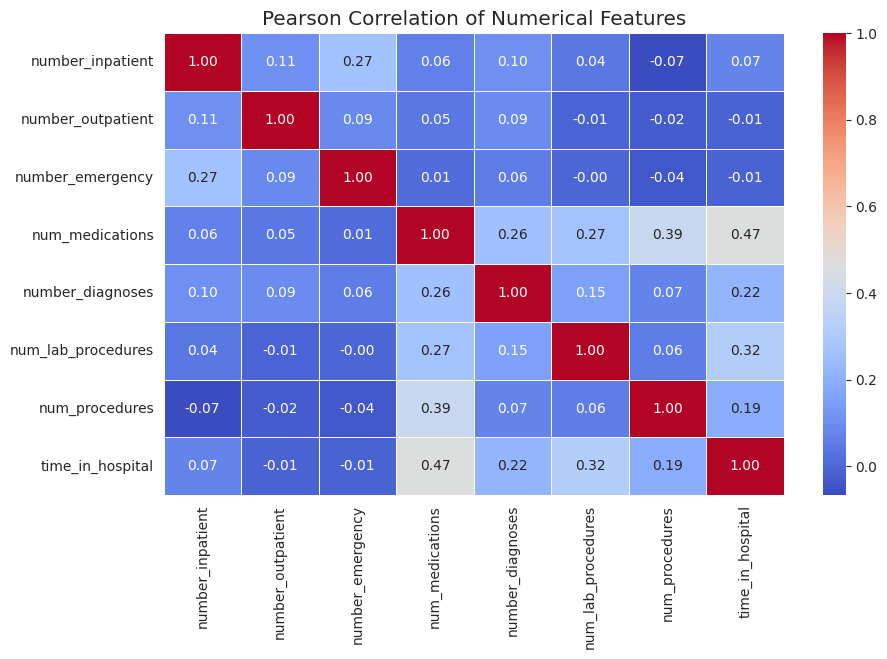

In [487]:
temp_data = diabetic_data[NUMERICAL_COLUMNS]
data_corr = temp_data.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(data_corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Pearson Correlation of Numerical Features')
plt.show()

#### 2.1.2 Categorical features
- The feature **readmitted** has incredibly weak correlation with all categorical features... we're not in luck.
- Closer attention should be kept in consideration to **insulin**, since it shows strong correlation with both change and diabetesMed.
- Some medications show slightly higher association (metformin, glipizide, pioglitazione)... with both change and diabetesMed.

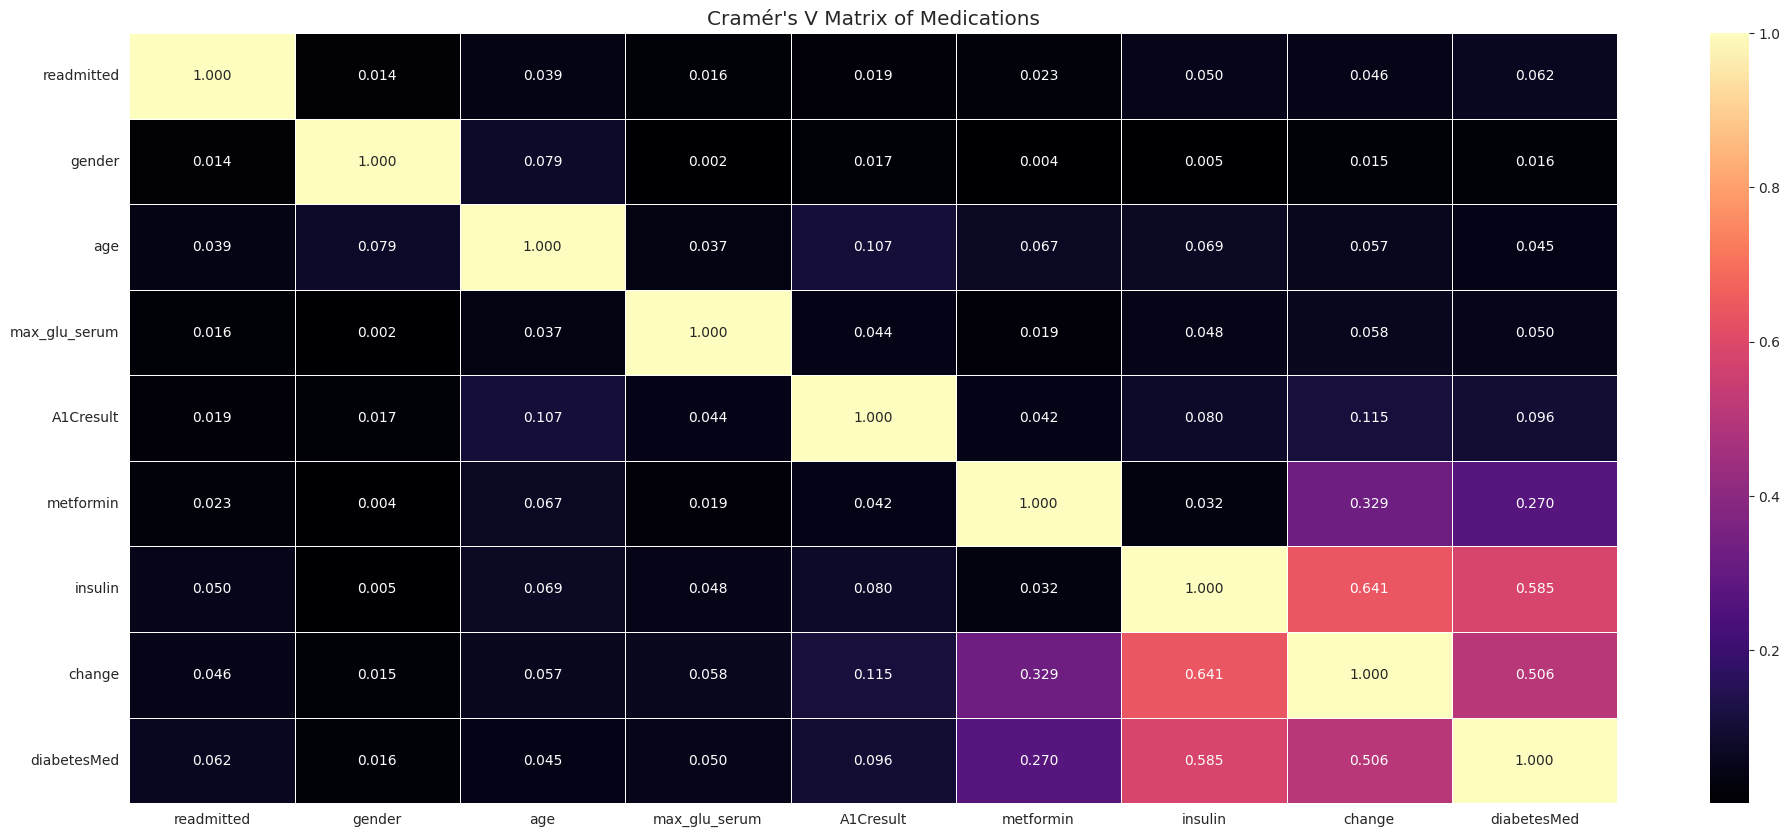

In [488]:
plt.figure(figsize=(24, 10))  # Set the figure size
cramer_matrix(
    data=diabetic_data,
    columns=CATEGORICAL_COLUMNS,
    linewidths=0.5,
    cmap = 'magma', fmt='.3f'
)
plt.title("Cramér's V Matrix of Medications")
plt.show()

#### 2.1.3 Categorical-numerical features
- The feature **number_impatient** seems to have a decent association with number_impatient.
- Other features also show a bit of association with readmission (number_diagnosis, number_emergency), but the associations are noticeably weaker.

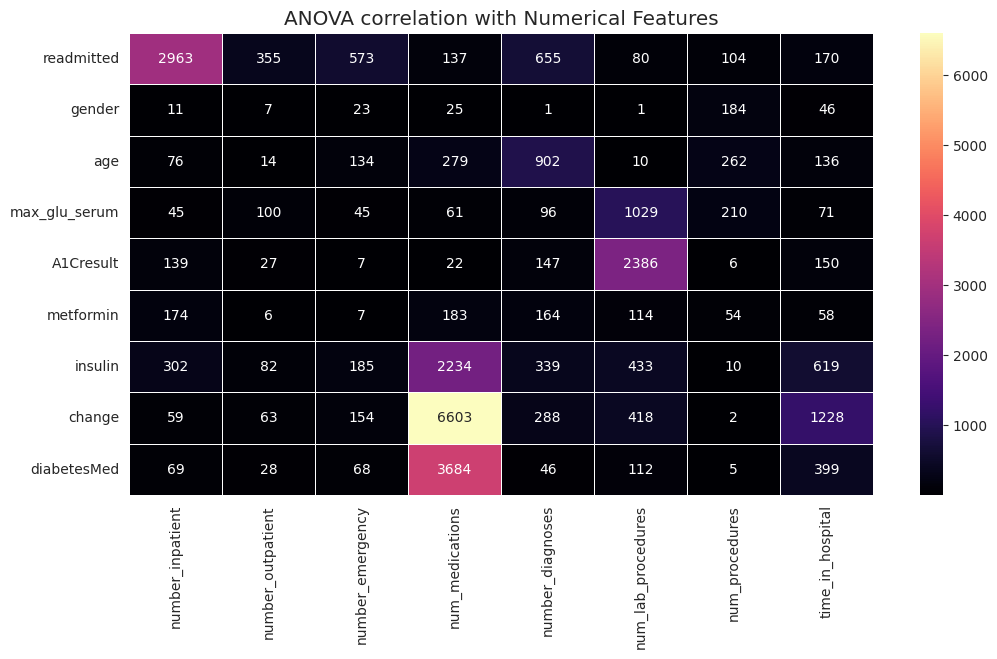

In [489]:
plt.figure(figsize=(12, 6))  # Set the figure size
anova_matrix(
    data=diabetic_data,
    categorical_cols=CATEGORICAL_COLUMNS,
    numerical_cols=NUMERICAL_COLUMNS,
    linewidths=0.5,
    cmap = 'magma', fmt='.0f'
)
plt.title('ANOVA correlation with Numerical Features')
plt.show()

### 2.2 Bivariate Analysis with Readmission
Exploring the relationship of multiple features with readmission status.

#### 2.2.1 Non-medication features

For **A1Cresult**, there doesn't seem to be any direct visible relationship with the readmissions.

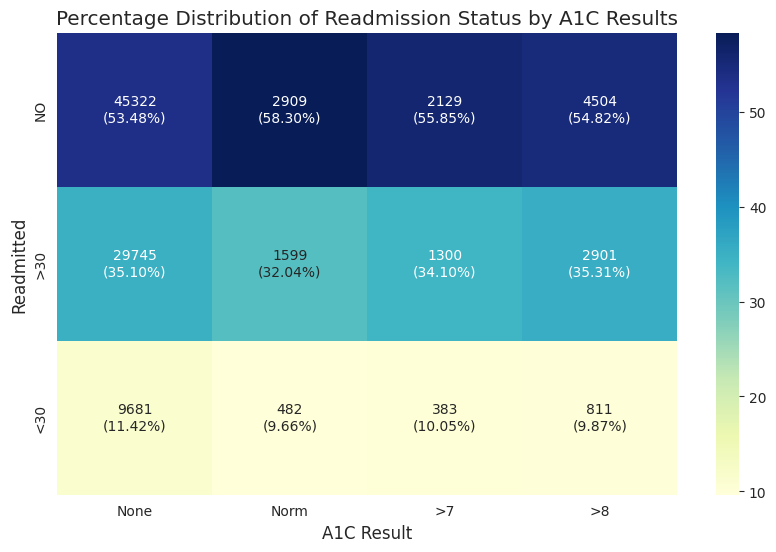

In [490]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='A1Cresult',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    columns=['None', 'Norm', '>7', '>8']
)

plt.title('Percentage Distribution of Readmission Status by A1C Results')
plt.xlabel('A1C Result')
plt.ylabel('Readmitted')
plt.show()

For **max_glu_serum**, there is a visible direct correlation with readmission rates. For people that were readmitted within 30 days, but also for those readmitted after 30 days, readmission rates increase with the increase of glucose. For all those people that were not readmitted, there is an inverse relationship with the increase of glucose levels.

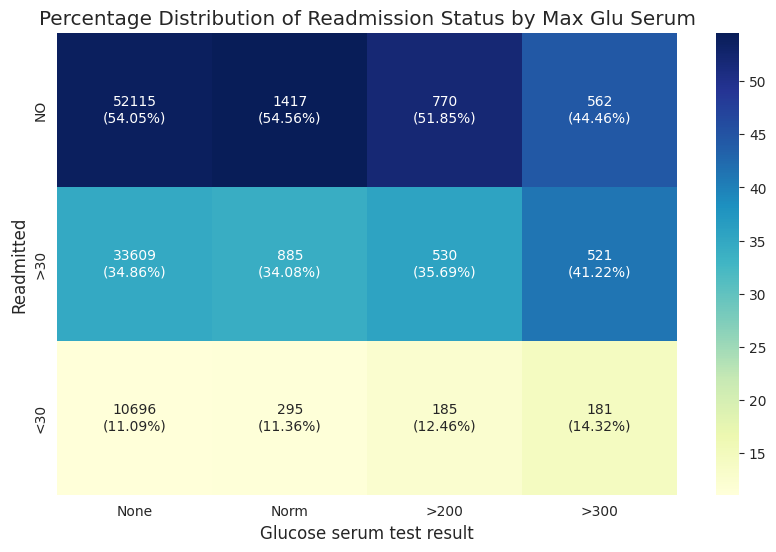

In [491]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='max_glu_serum',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    columns=['None', 'Norm', '>200', '>300']
)

plt.title('Percentage Distribution of Readmission Status by Max Glu Serum')
plt.xlabel('Glucose serum test result')
plt.ylabel('Readmitted')
plt.show()

For **age**, there is a very slight correlation with readmission rates. Percentage of readmitted people, both for <30 and >30, is directly proportional up to 20 years. After the 20s, we notice an attenuation of values, meaning that the readmission percentage does not increase as the age increases, but remains stable.

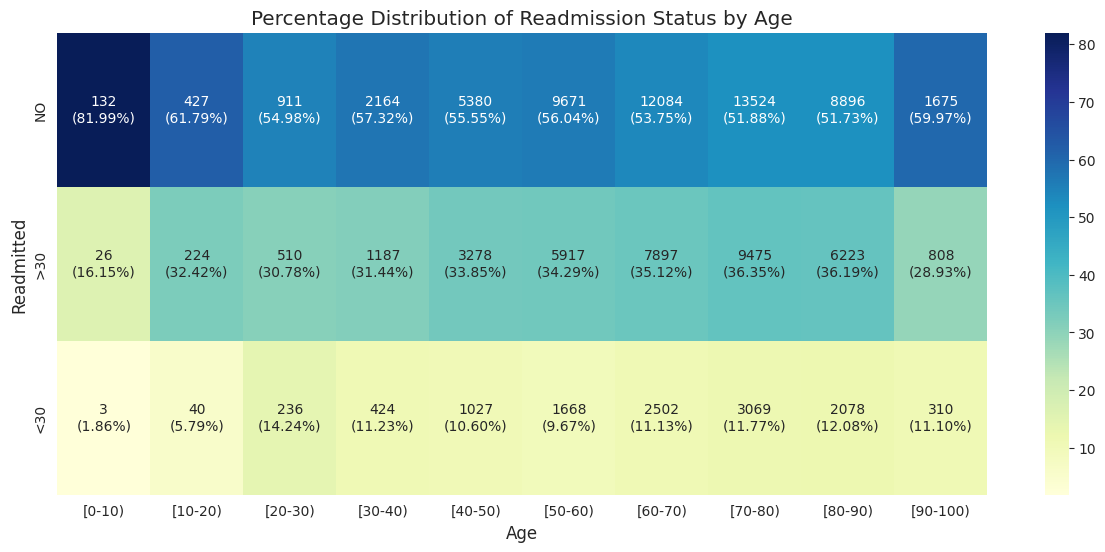

In [492]:
plt.figure(figsize=(15, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='age',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    columns=[
        '[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
        '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)'
    ]
)

plt.title('Percentage Distribution of Readmission Status by Age')
plt.xlabel('Age')
plt.ylabel('Readmitted')
plt.show()

For both **gender** and **race**, there is no visible correlation with readmissions. _Too bad, we can't make racist elmo._ 👀

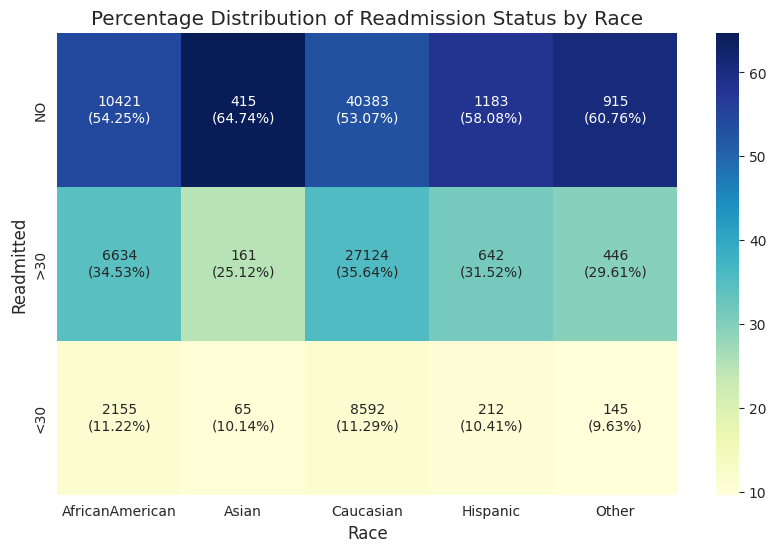

In [493]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='race',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    # columns=[0, 1]
)

plt.title('Percentage Distribution of Readmission Status by Race')
plt.xlabel('Race')
plt.ylabel('Readmitted')
plt.show()

For **change**, there is a small correlation with readmissions. A change in medication seems to lead to easier readmission.

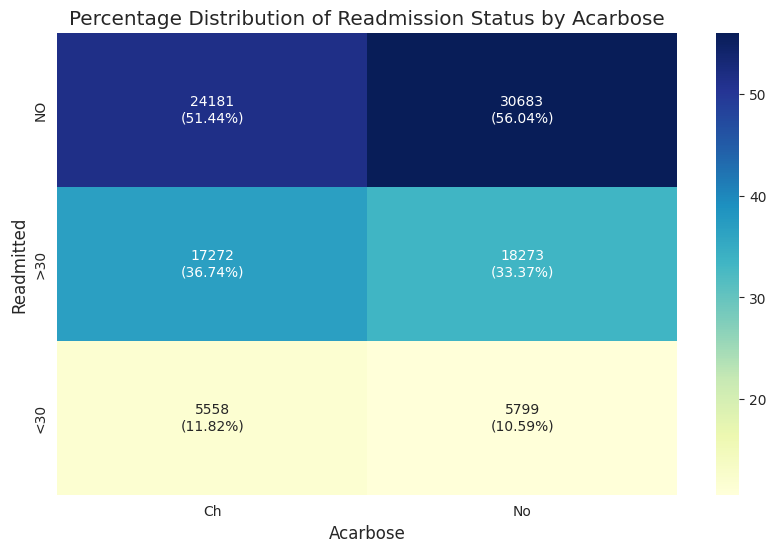

In [494]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='change',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    # columns=[0, 1]
)


plt.title('Percentage Distribution of Readmission Status by Acarbose')
plt.xlabel('Acarbose')
plt.ylabel('Readmitted')
plt.show()

For **diabetesMed**, there is a small correlation with readmissions. Subministration of diabetes medications seems to lead to easier readmission.

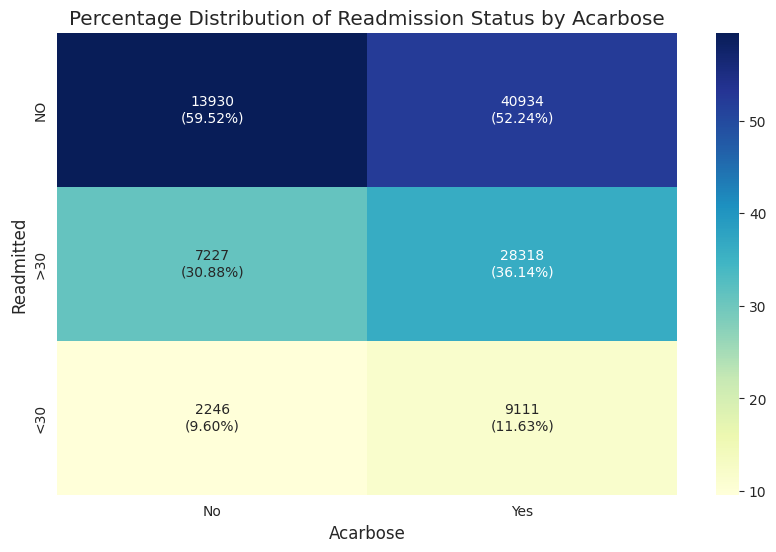

In [495]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='diabetesMed',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    # columns=[0, 1]
)


plt.title('Percentage Distribution of Readmission Status by Acarbose')
plt.xlabel('Acarbose')
plt.ylabel('Readmitted')
plt.show()

#### 2.2.2 Medication features

For **insulin**, if you leave unmodified, everything is fine... if you change the dosage, shit hits the fan.

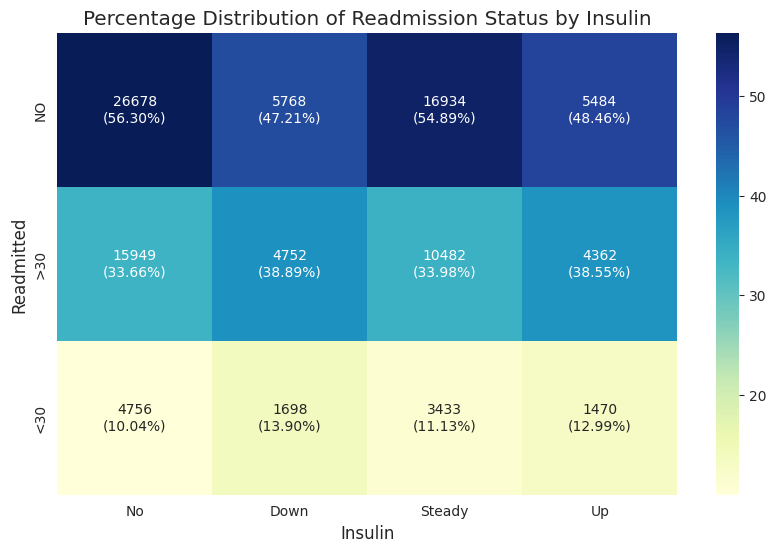

In [496]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='insulin',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    columns=['No', 'Down', 'Steady', 'Up']
)

plt.title('Percentage Distribution of Readmission Status by Insulin')
plt.xlabel('Insulin')
plt.ylabel('Readmitted')
plt.show()

For **metmorfin**, there is no visible correlation whatsover...

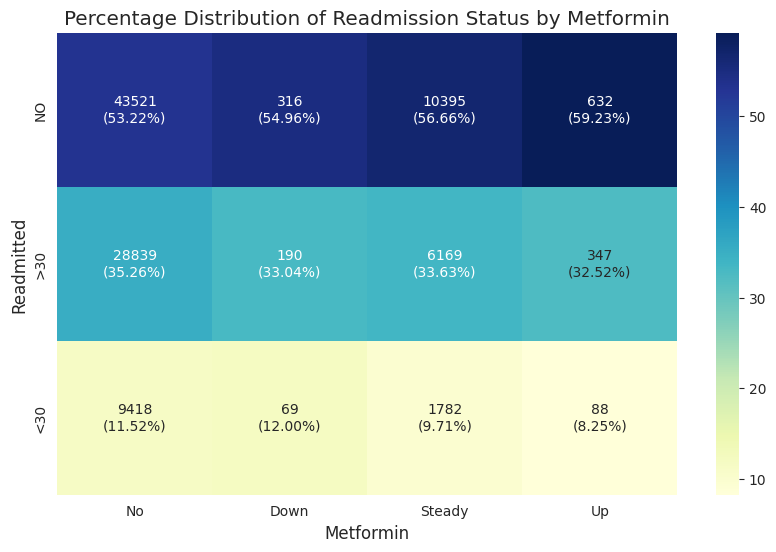

In [497]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='metformin',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    columns=['No', 'Down', 'Steady', 'Up']
)

plt.title('Percentage Distribution of Readmission Status by Metformin')
plt.xlabel('Metformin')
plt.ylabel('Readmitted')
plt.show()

## **3. Preprocessing**
Modifying and casting data, imputing missing values, creating new features, and so on.

### 3.1 Data Pre-Cleaning
Handling duplicate entries, and removing incomplete/unnecessary columns.

#### 3.1.1 Duplicates
Looking for duplicate instances, by excluding the reference to the patient and encounter identifiers. Luckily, there are none of them.

In [498]:
temp_data = diabetic_data.drop(columns=['encounter_id', 'patient_nbr'])
duplicates = temp_data[temp_data.duplicated()]
duplicates

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted


#### 3.1.2 Pseudo-duplicates

Keep one visit per patient within each age group. This is to make sure that there are no "pseudo-duplicate" instances, in the sense that have very similar traits since they relate to the same patient.

In [499]:
visit_counts = diabetic_data.groupby('patient_nbr').size().reset_index(name='visit_count')
visit_counts_sorted = visit_counts.sort_values(by='visit_count', ascending=False)
visit_counts_sorted

,patient_nbr,visit_count
54474,88785891,40
32927,43140906,28
3515,1660293,23
17018,23199021,23
54057,88227540,23
...,...,...
71492,188703698,1
71491,188692781,1
71490,188663279,1
16,6309,1


We group encounters by patient and age group, and we want to take only the first encounter from each group. This maximizes the chance that the selected visits are temporally further apart from each other, thus being more different.

In [500]:
grouped_data = diabetic_data.groupby(['patient_nbr', 'age'])
unique_visits = grouped_data.first().reset_index()

unique_visits

,patient_nbr,age,encounter_id,race,gender,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,135,[50-60),24437208,Caucasian,Female,None,2,1,1,8,None,Cardiology,77,6,33,0,0,0,401,997,560,8,None,None,Steady,No,No,No,No,No,No,Down,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,<30
1,378,[50-60),29758806,Caucasian,Female,None,3,1,1,2,None,Surgery-Neuro,49,1,11,0,0,0,722,305,250,3,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
2,729,[80-90),189899286,Caucasian,Female,None,1,3,7,4,MC,InternalMedicine,68,2,23,0,0,0,820,493,E880,9,None,>7,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,774,[80-90),64331490,Caucasian,Female,None,1,1,7,3,None,InternalMedicine,46,0,20,0,0,0,274,427,416,9,None,>8,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,NO
4,927,[30-40),14824206,AfricanAmerican,Female,None,1,1,7,5,None,InternalMedicine,49,0,5,0,0,0,590,220,250,3,None,None,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73087,189351095,[80-90),418513058,Caucasian,Female,None,1,1,7,1,None,None,73,1,11,0,0,0,285,401,496,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
73088,189365864,[60-70),359719064,Other,Male,None,1,1,7,3,HM,InternalMedicine,56,1,8,0,0,0,584,250.02,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO
73089,189445127,[80-90),338462954,Caucasian,Female,None,1,1,7,3,None,None,39,0,18,0,0,0,486,414,733,9,None,None,Steady,No,No,No,No,No,Up,No,No,No,Steady,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO
73090,189481478,[40-50),443811536,Caucasian,Female,None,1,4,7,14,MD,None,69,0,16,0,0,0,295,305,250,5,None,>7,Up,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30


In [501]:
diabetic_data = unique_visits

This approach drastically reduced the number of encounters for all patients. It looks like all visits where concentrated in some specific periods of their lives.
This also means that all those encounters would have shared many features, with minimal variations. By taking only one of them for each age group, we are able to capture the patient condition, without having "pseudo-duplicates".

In [502]:
visit_counts = diabetic_data.groupby('patient_nbr').size().reset_index(name='visit_count')
visit_counts_sorted = visit_counts.sort_values(by='visit_count', ascending=False)
visit_counts_sorted

,patient_nbr,visit_count
1703,688347,2
63432,103049865,2
19898,23945913,2
51966,85550139,2
30111,40914792,2
...,...,...
24028,27974520,1
24027,27971325,1
24026,27968004,1
24025,27963765,1


#### 3.1.3 Dropping incomplete/irrelevant/unbalanced features
Dropping columns with too many missing values, that are extremely unbalanced towards one specific value, or that are irrelevant for the analysis.

- Feature `encounter_id` can simply be dropped. We want to keep `patient_nbr` for now, since it might be useful to extract further data later on.
- Feature `weight` is missing almost 97% of values, and is simply useless at this point.
- Feature `payer_code` is missing almost 40% of values, and a quick analysis didn't show anything relevant, so it can be discarded.
- Many drugs have never been prescribed (like `nateglinide`, `acarbose`, `examide`, and combination medications), which means that both the assumption and/or change in dosage are exceptional cases by themselves. Due to the very low variance of cases, we're better off ignoring them.

In [503]:
diabetic_data.describe(include=['O'])

,age,race,gender,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,73092,71222,73092,2919,42518,39378,73082,72829,72017,73092,73092,73092,73092,73092,73092,73092,73092,73092,73092,73092,73092,73092,73092,73092,73092,73092,73092,73092,73092,73092,73092,73092,73092,73092,73092,73092,73092
unique,10,5,3,9,17,70,699,727,759,4,4,4,4,4,4,4,2,4,4,2,4,4,3,4,2,2,1,1,4,4,2,1,2,2,2,2,3
top,[70-80),Caucasian,Female,[75-100),MC,InternalMedicine,414,250,250,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
freq,18584,54792,38884,1227,21669,11436,5307,5077,9210,69513,59841,57828,72132,72582,73019,69271,73091,63787,65076,73072,67673,68297,72882,73069,73089,73060,73092,73092,35540,72580,73085,73092,73090,73091,40262,55587,43700


In [504]:
diabetic_data = diabetic_data.drop(columns=[
    'encounter_id', 'weight', 'payer_code',
    'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide',
    'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol',
    'troglitazone', 'tolazamide', 'examide',
    'citoglipton', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'
])
diabetic_data.sample(5)

,patient_nbr,age,race,gender,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,insulin,change,diabetesMed,readmitted
29518,39422763,[70-80),AfricanAmerican,Female,3,1,1,4,None,51,0,6,0,0,0,435,427,402,8,None,None,No,No,No,No,NO
67621,108589545,[80-90),Caucasian,Female,1,3,7,10,None,46,0,24,0,0,1,682,733,428,9,None,None,No,Down,Ch,Yes,>30
46481,70276905,[80-90),Caucasian,Male,3,1,1,6,Gastroenterology,54,1,17,0,0,0,427,428,496,9,None,None,No,Steady,Ch,Yes,NO
66956,107144334,[40-50),None,Male,1,1,7,3,None,37,6,12,0,0,0,410,305,424,5,None,None,Steady,Steady,Ch,Yes,NO
72232,161221550,[40-50),Caucasian,Male,2,1,4,1,Cardiology,25,3,17,0,0,0,786,411,414,9,None,None,No,No,No,Yes,NO


### 3.2 Feature Transformation
Modifying existing features.

#### 3.2.0 Functions

In [505]:
def get_readmission_distribution(feature, column_name, sort_by='Total'):
    """
    Get the distribution of readmission status by a specific feature.

    Parameters
    ----------
    feature : str
        The feature to group by.
    column_name : str
        The column name to use for the feature.
    sort_by : {'Readmission', 'No Readmission', 'Total', 'Percentage'}, default='Total'
        The column to sort by.
    """
    # Group by 'feature' and 'readmitted' columns
    distrib = diabetic_data.groupby([feature, 'readmitted']).size().unstack(fill_value=0).reset_index()
    distrib.columns = [column_name, 'No Readmission', 'Readmission']

    # Add a 'Total' column
    distrib['Total'] = distrib['Readmission'] + distrib['No Readmission']

    # Add readmission 'Percentage' column
    distrib['Percentage'] = distrib['Readmission'] / distrib['Total']

    # Sort by 'Total' in descending order
    distrib.sort_values(by=sort_by, ascending=False, inplace=True)

    # Reset index
    distrib.reset_index(drop=True, inplace=True)
    return distrib

In [506]:
def zscore_filtering(data: pd.DataFrame, column: str, threshold: float, method: str = "mean", dtype=int):
    """
    Filters outliers in a column based on z-score and replaces them with either the mean or capped value.

    Arguments
    ---------
        data : pd.DataFrame
            The input DataFrame.
        column : str
            The column to filter.
        threshold : float
            The z-score threshold for identifying outliers.
        method : {'mean', 'capping'}, default='mean'
            The substitution method.
    """
    # Compute the z-score
    data['z_score'] = zscore(data[column])
    data['outlier_z'] = np.abs(data['z_score']) > threshold

    if method == "mean":
        # Calculate substitute value as the mean of inliers
        substitute_value = np.round(
            data[data['outlier_z'] == False][column].mean()
        )
    elif method == "capping":
        # Calculate the cap values
        upper_cap = np.round(
            data[column].mean() + threshold * data[column].std()
        )
        lower_cap = np.round(
            data[column].mean() - threshold * data[column].std()
        )
        # Substitute with the nearest threshold
        substitute_value = data[column].clip(lower=lower_cap, upper=upper_cap)
    else:
        raise ValueError("Invalid method. Use 'mean' or 'capping'.")

    # Replace outliers with the substitute value
    if method == "mean":
        data[column] = np.where(
            data['outlier_z'] == True,
            substitute_value,
            data[column]
        )
    elif method == "capping":
        data[column] = np.where(
            data['z_score'] > threshold,
            substitute_value,
            np.where(data['z_score'] < -threshold, substitute_value, data[column])
        )
        
    # Convert the column to the specified data type
    data[column] = data[column].astype(dtype)

    # Drop the temporary columns
    data.drop(columns=['z_score', 'outlier_z'], inplace=True)

#### 3.2.1 Renaming features

In [507]:
diabetic_data = diabetic_data.rename(columns={
    'number_inpatient': 'num_inpatient',
    'number_outpatient': 'num_outpatient',
    'number_emergency': 'num_emergency',
    'number_diagnoses': 'num_diagnoses',
    'change': 'diabetes_med_change',
    'diabetesMed': 'diabetes_med_provided'
})

#### 3.2.2 Readmissions

Since we are primarily interested in factors that lead to early readmission, we defined the `readmission` feature (outcome) as having two values: **readmitted**, if the patient was readmitted within 30 days of discharge or **otherwise**, which covers both readmission after 30 days and no readmission at all.

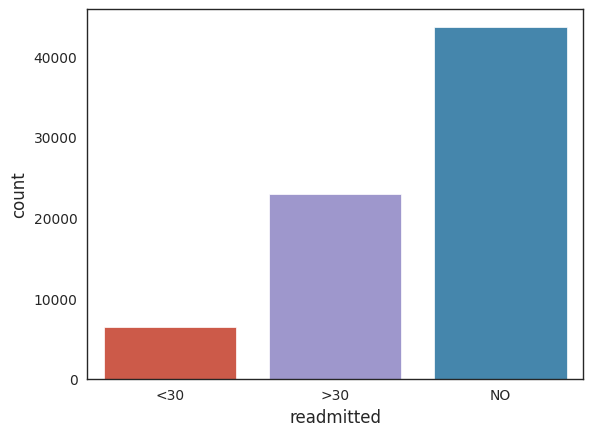

In [508]:
sns.countplot(
    data=diabetic_data,
    x='readmitted',
    hue='readmitted',
    order=['<30', '>30', 'NO']
)
plt.show()

In [509]:
diabetic_data['readmitted'] = diabetic_data['readmitted'].map(
    lambda x: 1 if x == '<30' else 0
)

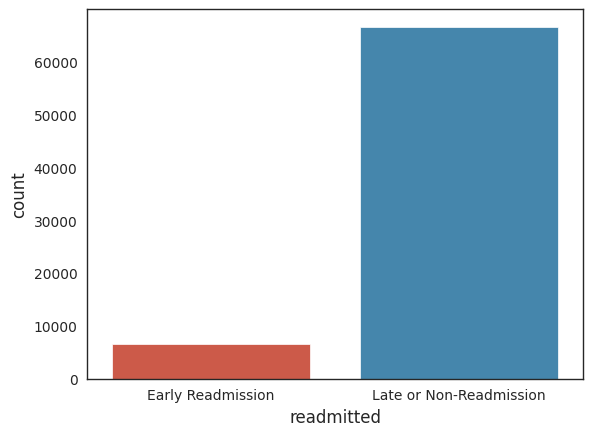

In [510]:
temp_data = diabetic_data.copy()
temp_data['readmitted'] = temp_data['readmitted'].map({1: 'Early Readmission', 0: 'Late or Non-Readmission'})

sns.countplot(
    data=temp_data,
    x='readmitted',
    hue='readmitted',
    order=['Early Readmission', 'Late or Non-Readmission']
)
plt.show()

In [511]:
# Get the percentages of early and late or non-readmissions
temp_data['readmitted'].value_counts(normalize=True) * 100


readmitted
Late or Non-Readmission    91.134461
Early Readmission           8.865539
Name: proportion, dtype: float64

#### 3.2.3 Discharge dispositions

Feature `discharge_disposition_id` is represented as a series of codes, representing discharge dispositions listed within the file `discharge_disposition_ids.csv`. We group them into five major classifications:

- Home / Home Care
- Transfer to another facility
- Expired (lease on life expired)
- Hospice Care
- Other (not included in the previous ones)

In [512]:
diabetic_data['discharge_disposition_id'].value_counts().sort_values(ascending=False)

discharge_disposition_id
1     45221
3      9044
6      8513
18     2511
2      1558
22     1438
11     1103
5       926
25      787
4       553
7       418
23      270
13      253
14      223
28       92
8        74
15       41
24       27
9         9
17        8
19        6
10        6
16        5
27        3
12        2
20        1
Name: count, dtype: int64

In [513]:
def map_discharge_disposition(discharge_disp_id):
    # Handle missing values
    if pd.isnull(discharge_disp_id):
        return None
    
    if discharge_disp_id in [1, 6, 8]:
        return 'Home / Home Care'
    elif discharge_disp_id in [2, 3, 4, 5, 10, 15, 16, 17, 22, 23, 24, 27, 28, 29, 30]:
        return 'Transfer to Another Facility'
    elif discharge_disp_id in [11, 19, 20, 21]:
        return 'Expired'
    elif discharge_disp_id in [13, 14]:
        return 'Hospice Care'
    else:
        return 'Other'

In [514]:
diabetic_data['discharge_disposition_group'] = diabetic_data['discharge_disposition_id'].apply(map_discharge_disposition)

We combine the cases of early readmission and late or non-readmission for all discharge disposition categories. We can clearly see that 'Home / Home care' is the predominant one. Also 'Trasfer to another facility' is interesting, since it stands out from the others by percentage of readmission.

In [515]:
discharge_counts = get_readmission_distribution('discharge_disposition_group', 'Discharge Disposition Group', sort_by='Total')
discharge_counts

,Discharge Disposition Group,No Readmission,Readmission,Total,Percentage
0,Home / Home Care,49817,3991,53808,0.074171
1,Transfer to Another Facility,11851,2120,13971,0.151743
2,Other,3377,350,3727,0.093909
3,Expired,1110,0,1110,0.000000
4,Hospice Care,457,19,476,0.039916


We simply create two boolean feature, one for when the patient is sent home or to home care, and another for when the patient is transferred to another facility, and we discard all other sources of admission.

In [516]:
diabetic_data['discharge_home'] = diabetic_data['discharge_disposition_group'].apply(
    lambda disch: 1 if disch == "Home / Home Care" else 0
)

diabetic_data['discharge_transfer'] = diabetic_data['discharge_disposition_group'].apply(
    lambda disch: 1 if disch == "Transfer to Another Facility" else 0
)

As a final touch, we also remove all expired (dead) patients, since they do not count towards readmission.

In [517]:
diabetic_data = diabetic_data[
    diabetic_data['discharge_disposition_group'] != 'Expired'
]

#### 3.2.4 Age

Feature `age` is represented as a series of age ranges. Let's try to visualize the patients' age distribution.

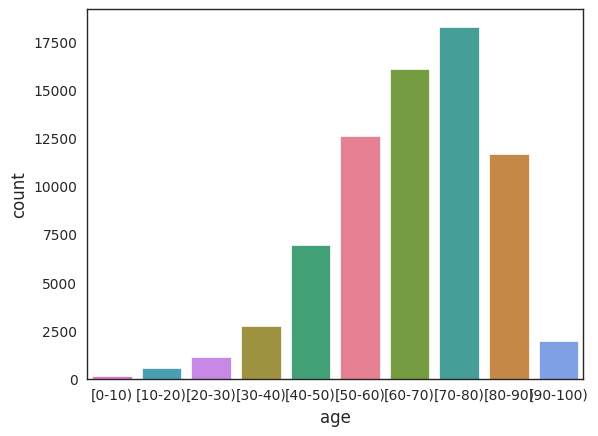

In [518]:
sns.countplot(
    data=diabetic_data,
    x='age',
    hue='age',
    order=[
        '[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
        '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)'
    ]
)
plt.show()

Higher ages are the predominant ones, and also the ones with higher percentages of readmission.

In [519]:
age_counts = get_readmission_distribution('age', 'Age', sort_by='Total')
age_counts

,Age,No Readmission,Readmission,Total,Percentage
0,[70-80),16384,1872,18256,0.102542
1,[60-70),14631,1450,16081,0.090169
2,[50-60),11662,904,12566,0.071940
3,[80-90),10426,1252,11678,0.107210
4,[40-50),6406,512,6918,0.074010
5,[30-40),2528,192,2720,0.070588
6,[90-100),1757,185,1942,0.095263
7,[20-30),1049,84,1133,0.074139
8,[10-20),509,26,535,0.048598
9,[0-10),150,3,153,0.019608


All age groups have a mathematical ordering (some are bigger than others, and viceversa), so it makes sense to apply ordinal encoding.

In [520]:
encoder = OrdinalEncoder()
encoder.fit(diabetic_data[['age']])
diabetic_data['age'] = encoder.transform(diabetic_data[['age']])

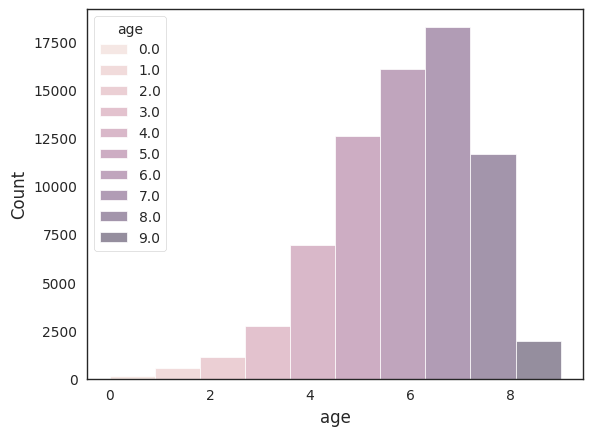

In [521]:
sns.histplot(
    data=diabetic_data,
    x='age',
    hue='age',
    bins=10
)
plt.show()

#### 3.2.5 Race

Let's try to enable racism in our models with the feature `race`.

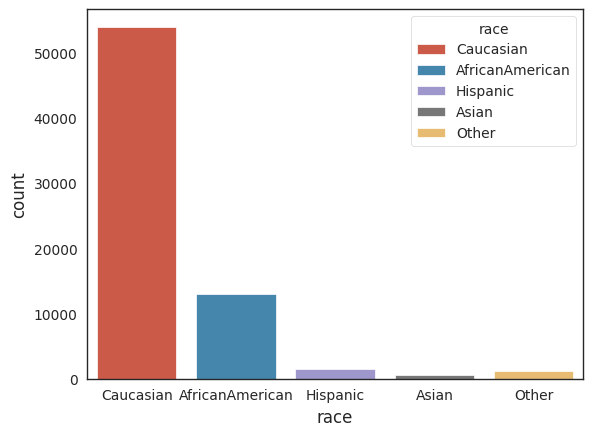

In [522]:
sns.countplot(
    data=diabetic_data,
    x='race',
    hue='race'
)
plt.show()

The only thing we are able to see is that most people are Caucasian. The distribution of readmission does not highlight anything particular either. Guess we can't make racist elmo then.

In [523]:
race_counts = get_readmission_distribution('race', 'Race', sort_by='Total')
race_counts

,Race,No Readmission,Readmission,Total,Percentage
0,Caucasian,48958,4984,53942,0.092396
1,AfricanAmerican,11859,1127,12986,0.086786
2,Hispanic,1410,124,1534,0.080834
3,Other,1097,81,1178,0.068761
4,Asian,458,42,500,0.084000


#### 3.2.6 Gender

Let's try to enable sexism in our models with the feature `gender`.

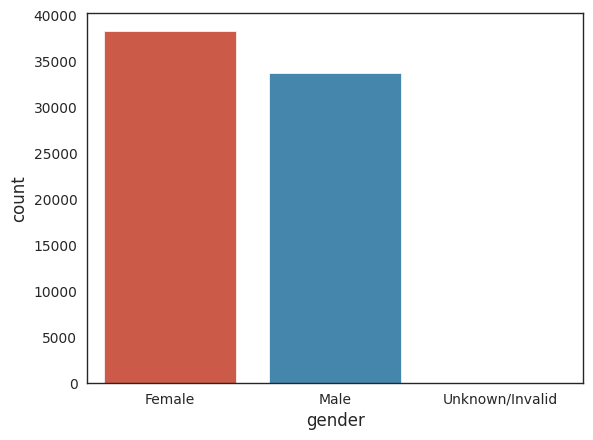

In [524]:
sns.countplot(
    data=diabetic_data,
    x='gender',
    hue='gender'
)
plt.show()

There is a fairly equal distribution between male and female, plus three 'unknown/invalid' genders... MOFOs who decided to call 'other' genders 'invalid' are quite rude, but hey... 2000s.

That topic aside, the percentages of readmission are the same between both groups, there is no visible variance between them.

In [525]:
gender_counts = get_readmission_distribution('gender', 'Gender', sort_by='Total')
gender_counts

,Gender,No Readmission,Readmission,Total,Percentage
0,Female,34835,3477,38312,0.090755
1,Male,30664,3003,33667,0.089197
2,Unknown/Invalid,3,0,3,0.000000


Despite no variance in readmission rates, both classes are quite balanced. A model might be able to pick up relationships with other features that are not immediately visible to the naked eye, so we'll keep it.

Since there are only three cases of 'other' genders, we'll turn them to the most common, and create a boolean feature for gender.

In [526]:
diabetic_data.loc[diabetic_data['gender'] == 'Unknown/Invalid', 'gender'] = 'Female'

diabetic_data['gender'] = diabetic_data['gender'].map({
    'Female': 1,
    'Male': 0
})

#### 3.2.7 Time in hospital

Feature `time_in_hospital` is used to represent the amount of days spent in hospital by the patient. Let's see its distribution.

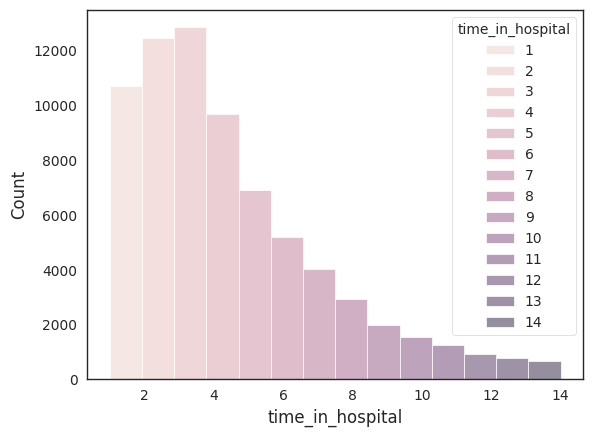

In [527]:
sns.histplot(
    data=diabetic_data,
    x='time_in_hospital',
    hue='time_in_hospital',
    bins=14
)
plt.show()

It's pretty clear that early-readmitted patients tend to have more days in hospital, and also a higher mean of hospital days.

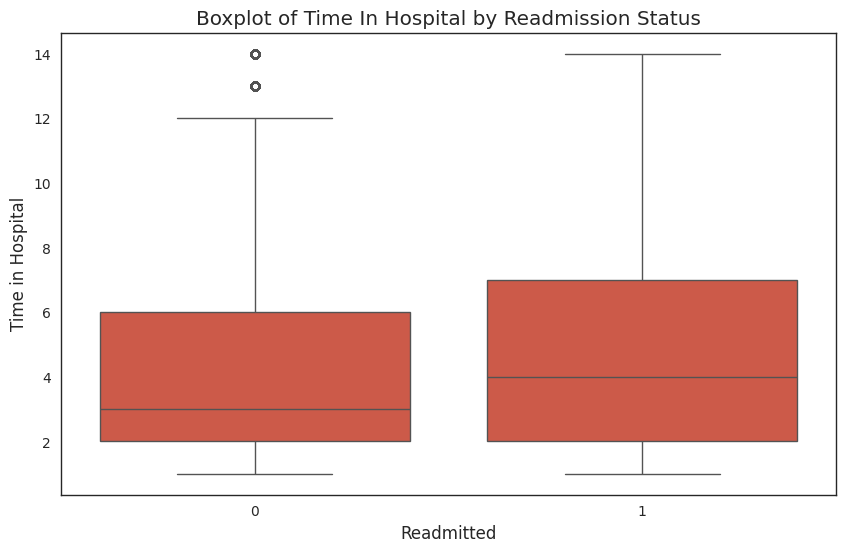

In [528]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='time_in_hospital')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Time in Hospital')

# Show the plot
plt.show()

There is also a visible relationship with the age group of the patient. The higher the age, the more days in hospital are encountered.

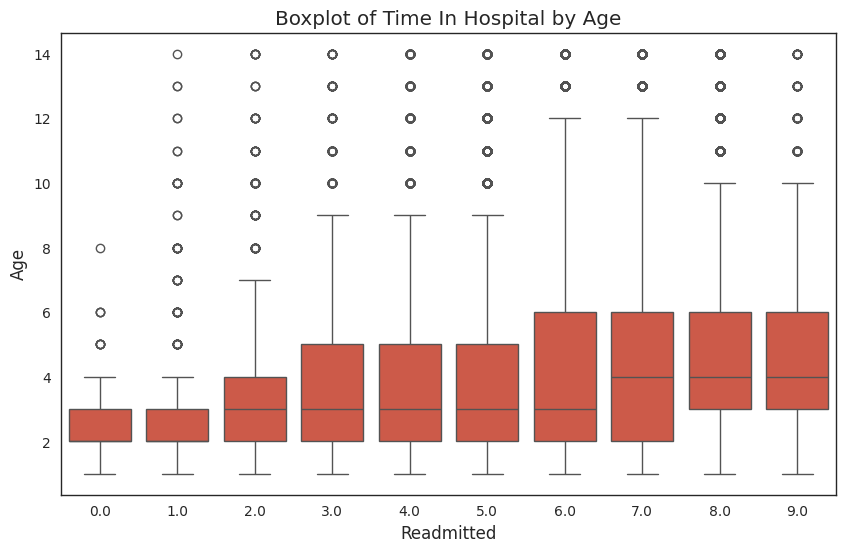

In [529]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='age', y='time_in_hospital')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Age')
plt.xlabel('Readmitted')
plt.ylabel('Age')

# Show the plot
plt.show()

Let's apply a global z-score filtering of the time spent in hospital.

In [530]:
zscore_filtering(data=diabetic_data, column='time_in_hospital', threshold=3, method='capping', dtype=float)

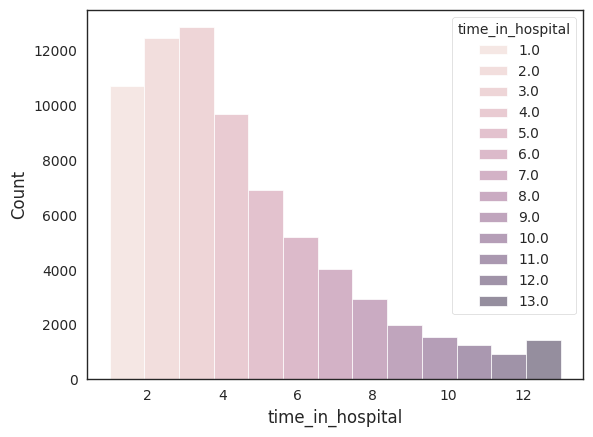

In [531]:
sns.histplot(
    data=diabetic_data,
    x='time_in_hospital',
    hue='time_in_hospital',
    bins=13
)
plt.show()

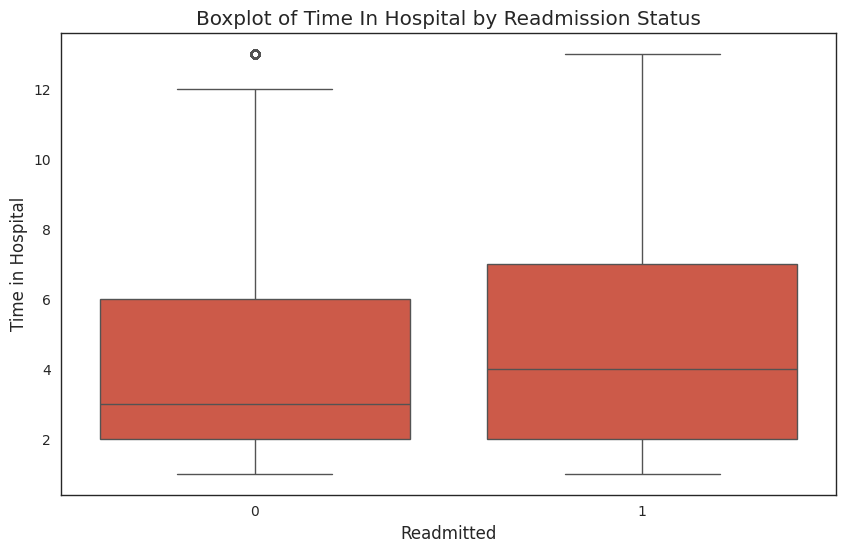

In [532]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='time_in_hospital')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Time in Hospital')

# Show the plot
plt.show()

#### 3.2.8 Lab procedures

Feature `num_lab_procedures` is used to represent the number of laboratory procedures conducted on the patient. Let's see its distribution.

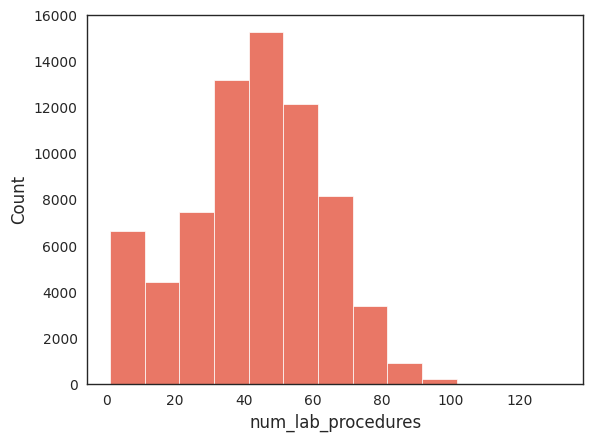

In [533]:
sns.histplot(
    data=diabetic_data,
    x='num_lab_procedures',
    binwidth=10
)
plt.show()

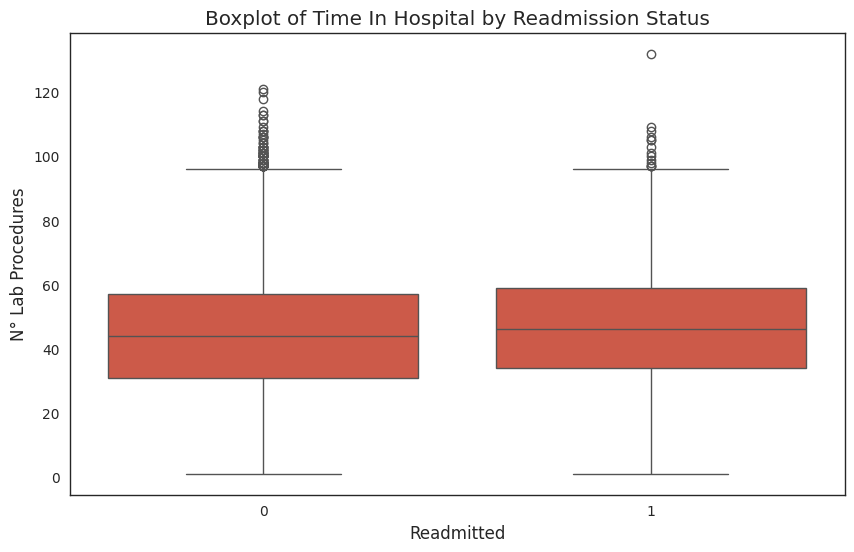

In [534]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_lab_procedures')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('N° Lab Procedures')

# Show the plot
plt.show()

Let's apply a global z-score filtering.

In [535]:
zscore_filtering(data=diabetic_data, column='num_lab_procedures', threshold=2.5, method='mean')

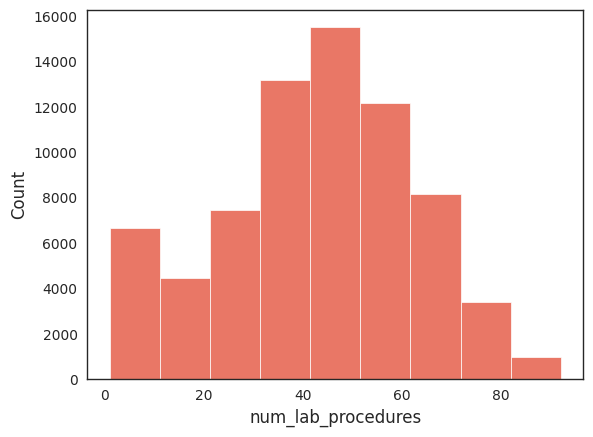

In [536]:
sns.histplot(
    data=diabetic_data,
    x='num_lab_procedures',
    binwidth=10
)
plt.show()

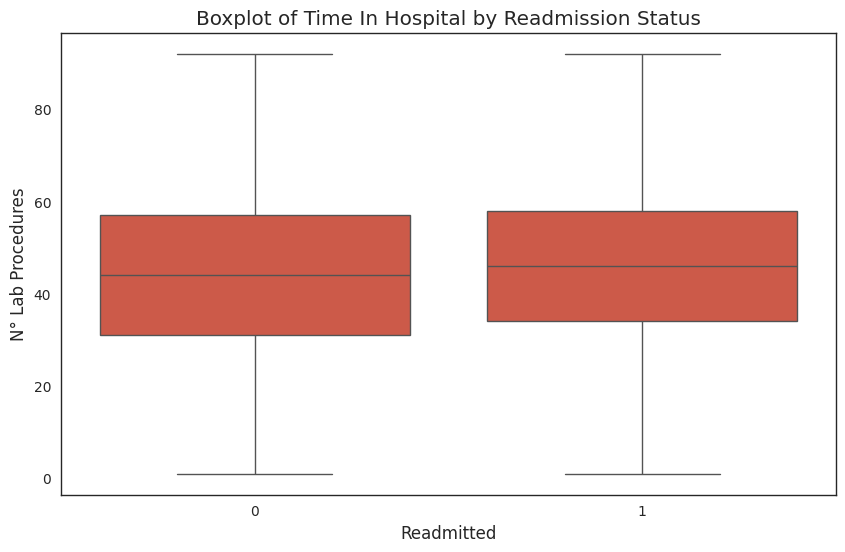

In [537]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_lab_procedures')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('N° Lab Procedures')

# Show the plot
plt.show()

#### 3.2.9 Non-lab procedures

Feature `num_procedures` is used to represent the number of non-laboratory procedures conducted on the patient. Let's see its distribution.

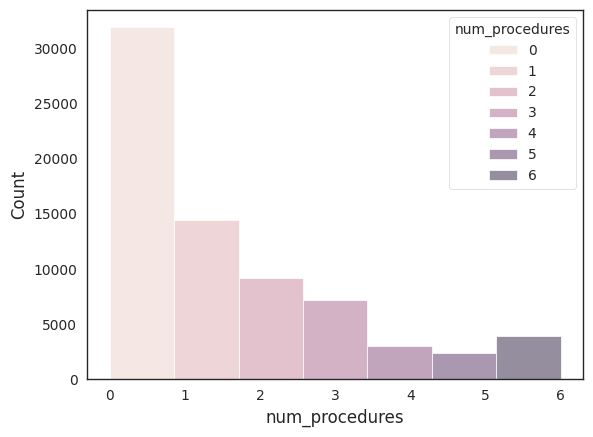

In [538]:
sns.histplot(
    data=diabetic_data,
    x='num_procedures',
    hue='num_procedures',
    bins=7
)
plt.show()

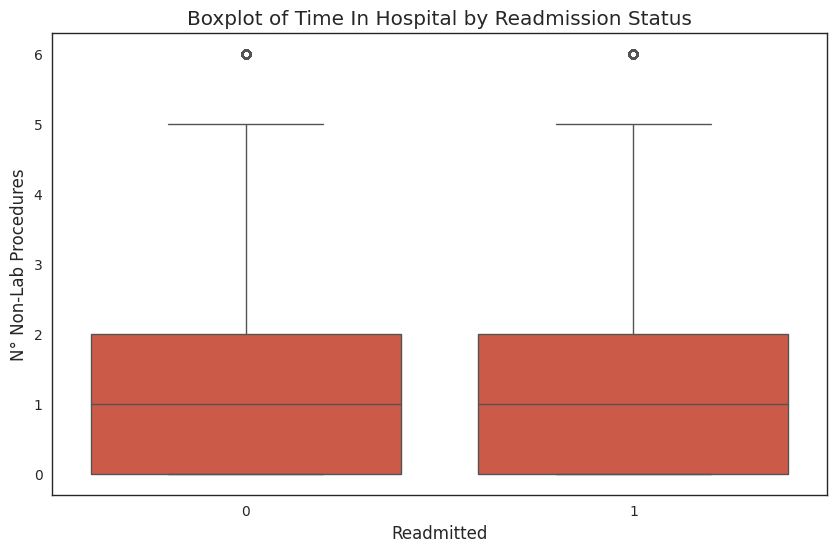

In [539]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_procedures')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('N° Non-Lab Procedures')

# Show the plot
plt.show()

Let's apply a global z-score filtering.

In [540]:
zscore_filtering(data=diabetic_data, column='num_procedures', threshold=3, method='mean')

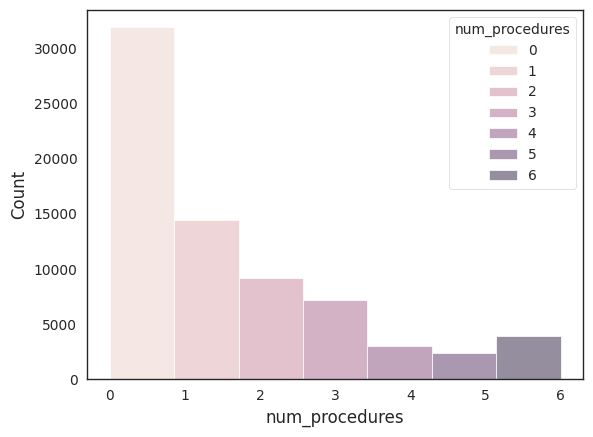

In [541]:
sns.histplot(
    data=diabetic_data,
    x='num_procedures',
    hue='num_procedures',
    bins=7
)
plt.show()

#### 3.2.10 Medications number

Feature `num_medications` is used to represent the number of medications subministered to a patient. Let's see its distribution.

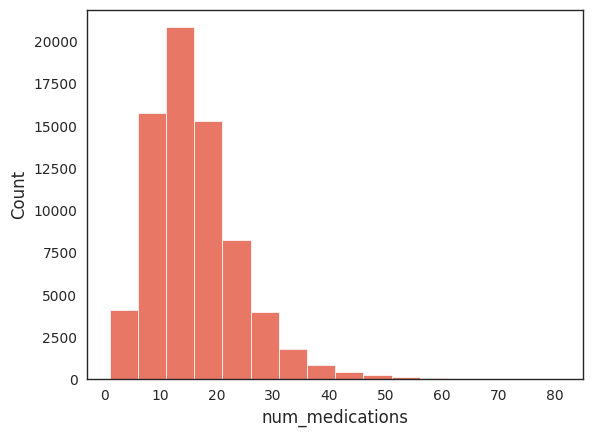

In [542]:
sns.histplot(
    data=diabetic_data,
    x='num_medications',
    binwidth=5
)
plt.show()

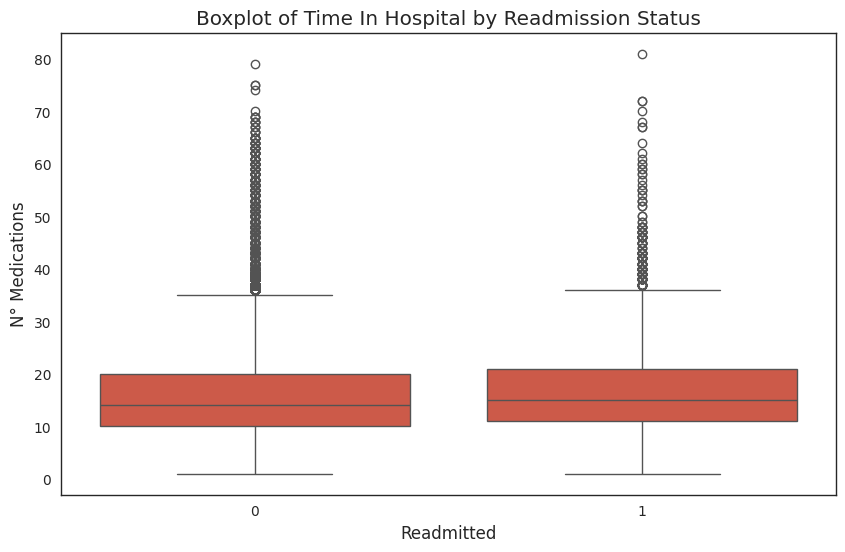

In [543]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_medications')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('N° Medications')

# Show the plot
plt.show()

Let's apply a global z-score filtering.

In [544]:
zscore_filtering(data=diabetic_data, column='num_medications', threshold=2.5, method='capping')

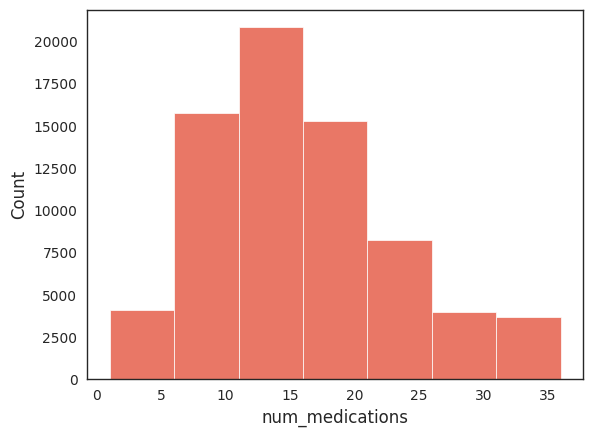

In [545]:
sns.histplot(
    data=diabetic_data,
    x='num_medications',
    binwidth=5
)
plt.show()

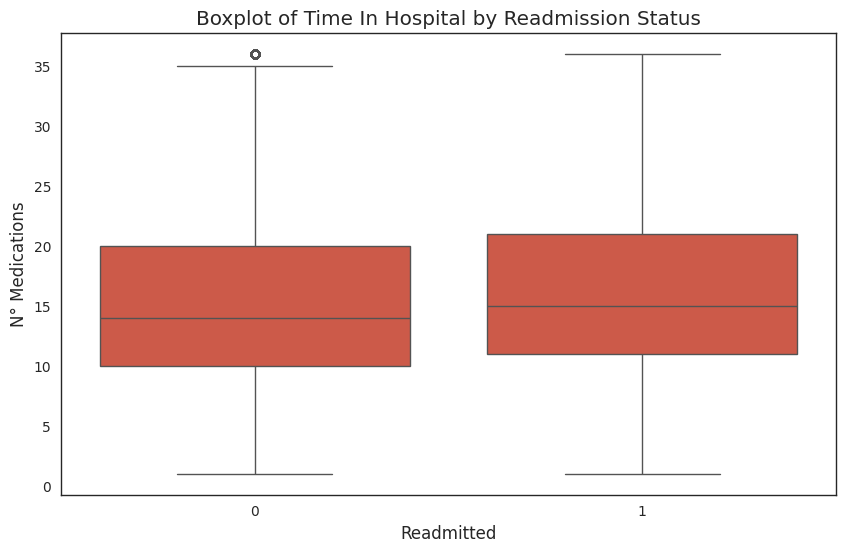

In [546]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_medications')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('N° Medications')

# Show the plot
plt.show()

#### 3.2.11 Diagnoses number

Feature `num_diagnoses` is used to represent the number of diagnoses discovered on a patient. Let's see its distribution.

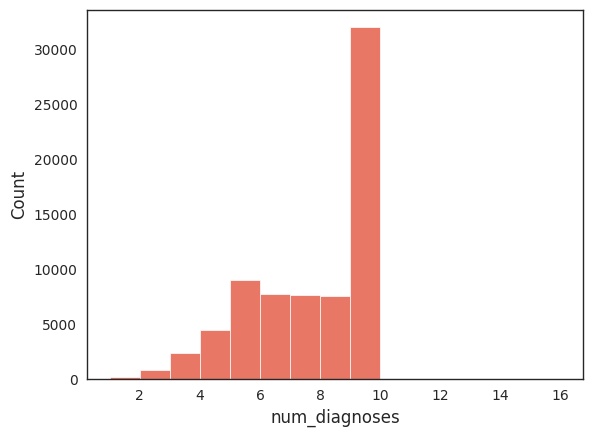

In [547]:
sns.histplot(
    data=diabetic_data,
    x='num_diagnoses',
    binwidth=1
)
plt.show()

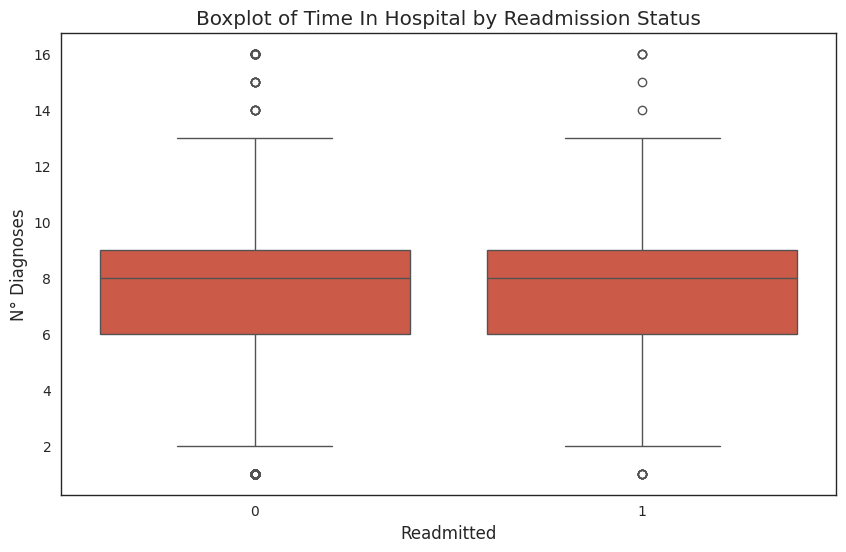

In [548]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_diagnoses')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('N° Diagnoses')

# Show the plot
plt.show()

Let's apply a global z-score filtering.

In [549]:
zscore_filtering(data=diabetic_data, column='num_diagnoses', threshold=2.5, method='mean')

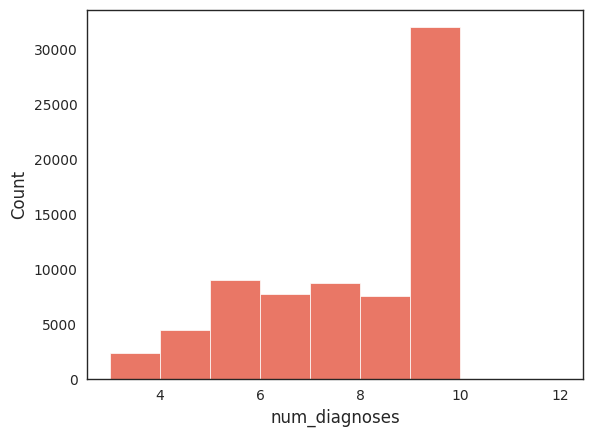

In [550]:
sns.histplot(
    data=diabetic_data,
    x='num_diagnoses',
    binwidth=1
)
plt.show()

#### 3.2.12 Inpatient visits

Feature `num_inpatient` is used to represent the number of impatient visits by a patient. Let's see its distribution.

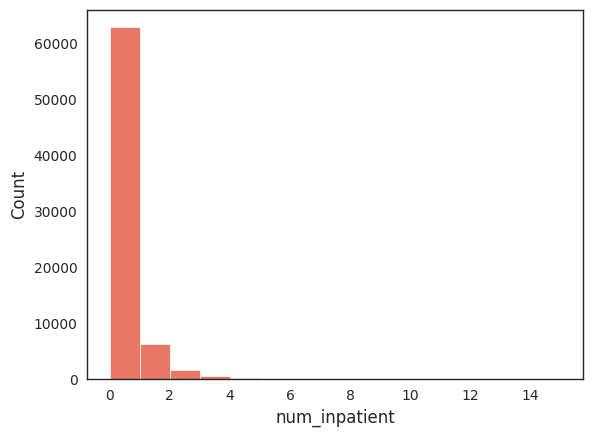

In [551]:
sns.histplot(
    data=diabetic_data,
    x='num_inpatient',
    binwidth=1
)
plt.show()

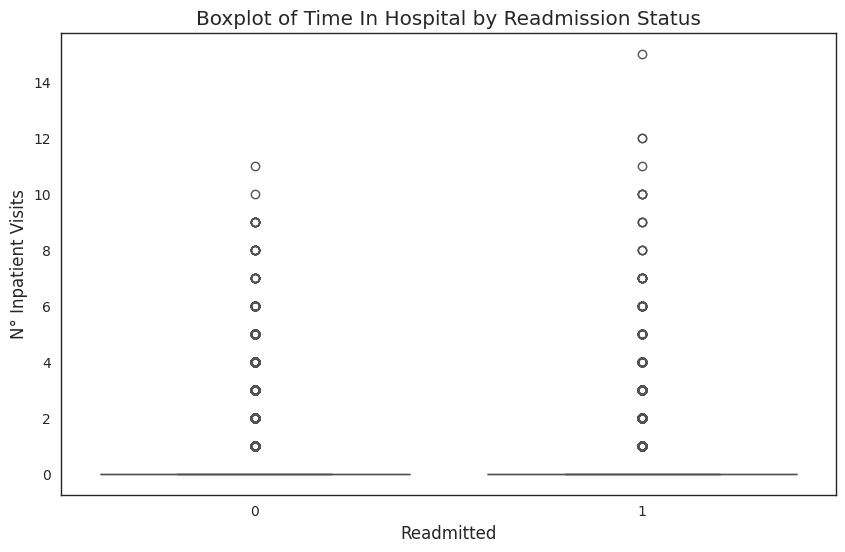

In [552]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_inpatient')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('N° Inpatient Visits')

# Show the plot
plt.show()

Let's apply a global z-score filtering.

In [553]:
zscore_filtering(data=diabetic_data, column='num_inpatient', threshold=3, method='capping')

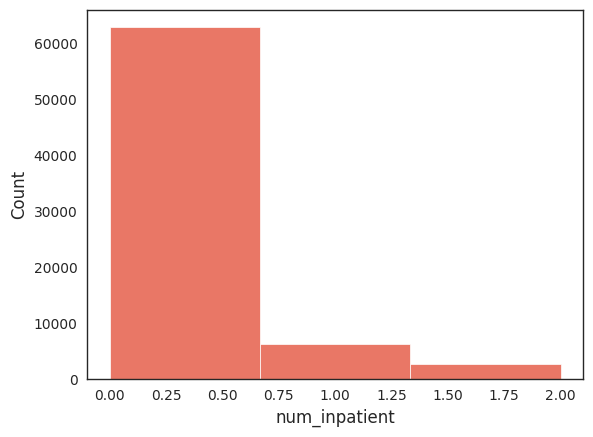

In [554]:
sns.histplot(
    data=diabetic_data,
    x='num_inpatient',
    bins=3
)
plt.show()

#### 3.2.13 Outpatient visits

Feature `num_outpatient` is used to represent the number of outpatient visits by a patient. Let's see its distribution.

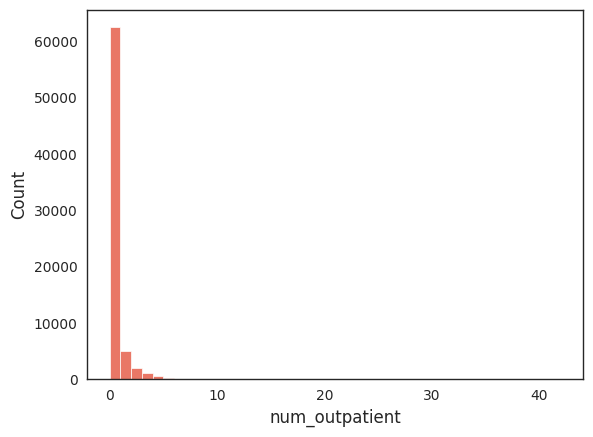

In [555]:
sns.histplot(
    data=diabetic_data,
    x='num_outpatient',
    binwidth=1
)
plt.show()

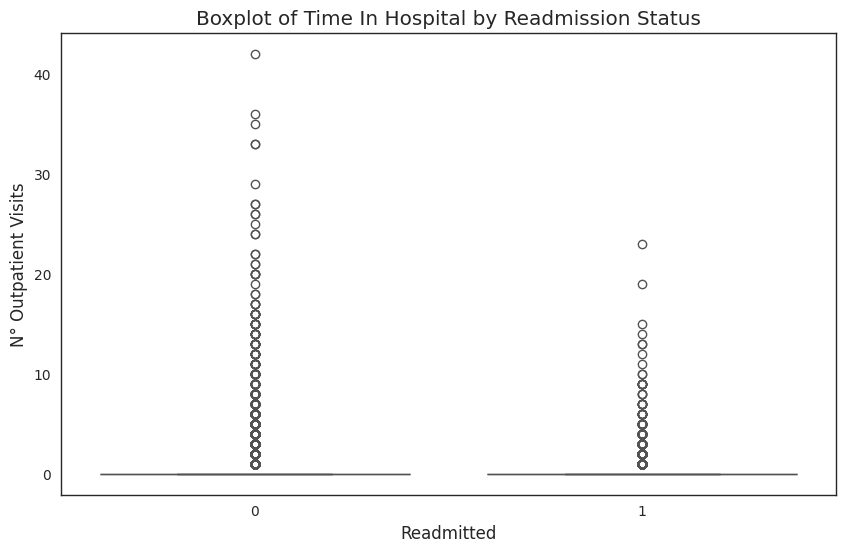

In [556]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_outpatient')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('N° Outpatient Visits')

# Show the plot
plt.show()

Let's apply a global z-score filtering.

In [557]:
zscore_filtering(data=diabetic_data, column='num_outpatient', threshold=3, method='capping')

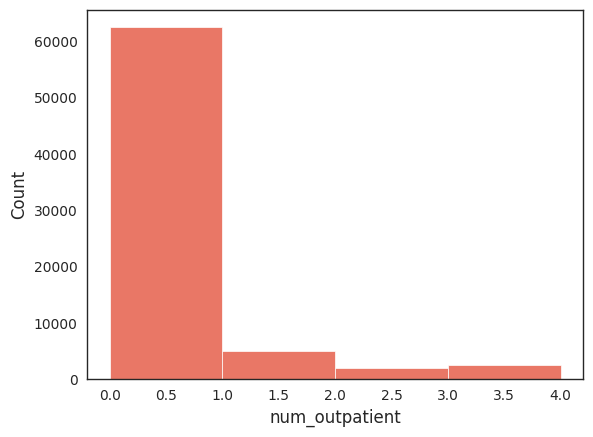

In [558]:
sns.histplot(
    data=diabetic_data,
    x='num_outpatient',
    bins=4
)
plt.show()

#### 3.2.14 Emergency visits

Feature `num_emergency` is used to represent the number of emergency visits by a patient. Let's see its distribution.

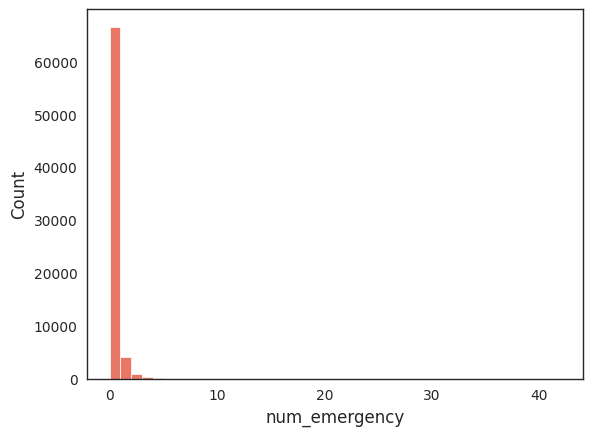

In [559]:
sns.histplot(
    data=diabetic_data,
    x='num_emergency',
    binwidth=1
)
plt.show()

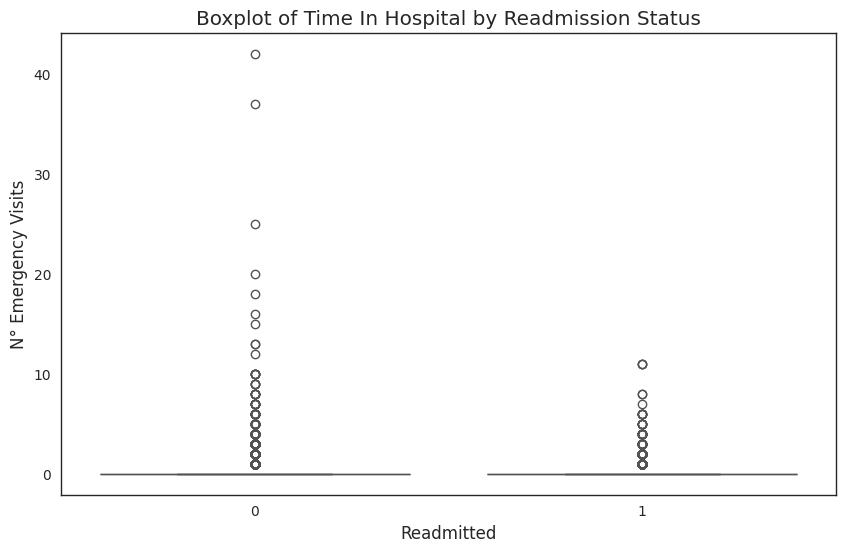

In [560]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_emergency')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('N° Emergency Visits')

# Show the plot
plt.show()

Let's apply a global z-score filtering.

In [561]:
zscore_filtering(data=diabetic_data, column='num_emergency', threshold=3, method='capping')

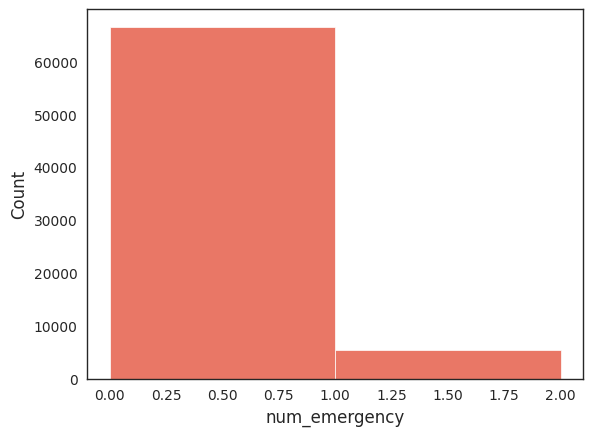

In [562]:
sns.histplot(
    data=diabetic_data,
    x='num_emergency',
    bins=2
)
plt.show()

#### 3.2.15 Diagnoses

It doesn't reallt make sense that some primary diagnoses are missing, we we will just impute them with the most common value. It makes sense instead for secondary and tertiary diagnoses to be missing (none were found for the patient), so we'll just consider them as missing.

In [563]:
imputer = SimpleImputer(missing_values=None, strategy='most_frequent')
diabetic_data['diag_1'] = pd.DataFrame(imputer.fit_transform(diabetic_data[['diag_1']]))

The `diag_1`, `diag_2`, and `diag_3` columns in the dataset represent diagnosis codes, encoded as ICD-9-CM (International Classification of Diseases, 9th Revision, Clinical Modification) codes. We would like to reduce their numbers by grouping them into categories. Let's start by using the official classifications from ICD-9-CM.

In [564]:
def map_icd9_to_category(code):
    if not code:
        return "Missing"
    try:
        code = str(code).strip()
        if code.startswith("V"):
            return "Supplementary (Factor Influencing Health)"
        elif code.startswith("E"):
            return "External Cause of Injury"
        else:
            num_code = float(code)
            if 250 <= num_code < 251:
                return "Diabetes"
            elif 1 <= num_code <= 139:
                return "Infectious and Parasitic"
            elif 140 <= num_code <= 239:
                return "Neoplasm"
            elif 240 <= num_code <= 279:
                return "Endocrine, Nutritional, or Metabolic"
            elif 280 <= num_code <= 289:
                return "Blood Disease"
            elif 290 <= num_code <= 319:
                return "Mental Disorder"
            elif 320 <= num_code <= 389:
                return "Nervous System Disease"
            elif 390 <= num_code <= 459:
                return "Circulatory System Disease"
            elif 460 <= num_code <= 519:
                return "Respiratory System Disease"
            elif 520 <= num_code <= 579:
                return "Digestive System Disease"
            elif 580 <= num_code <= 629:
                return "Genitourinary System Disease"
            elif 630 <= num_code <= 679:
                return "Pregnancy, Childbirth, or Puerperium"
            elif 680 <= num_code <= 709:
                return "Skin and Subcutaneous Tissue Disease"
            elif 710 <= num_code <= 739:
                return "Musculoskeletal System Disease"
            elif 740 <= num_code <= 759:
                return "Congenital Anomaly"
            elif 760 <= num_code <= 779:
                return "Certain Condition Originating in the Perinatal Period"
            elif 780 <= num_code <= 799:
                return "Symptom, Sign, and Ill-Defined Condition"
            elif 800 <= num_code <= 999:
                return "Injury and Poisoning"
            else:
                return "Other"
    except ValueError:
        return "Missing"

In [565]:
diabetic_data['diag_1_group'] = diabetic_data['diag_1'].apply(map_icd9_to_category)
diabetic_data['diag_2_group'] = diabetic_data['diag_2'].apply(map_icd9_to_category)
diabetic_data['diag_3_group'] = diabetic_data['diag_3'].apply(map_icd9_to_category)

We combine the cases of early readmission and late or non-readmission for all diagnoses categories, by summing contributions from all features (`diag_1`, `diag_2` and `diag_3`). We can see that the most common diagnoses across all three (primary, seconday and tertiary) are:

- Circulatory System Disease
- Diabetes
- Respiratory System Disease
- Endocrine, Nutritional, or Metabolic
- Genitourinary System Disease

In [566]:
# Compute readmission counts for each diagnosis group
readmission_counts_1 = get_readmission_distribution('diag_1_group', 'Diagnosis Group')
readmission_counts_2 = get_readmission_distribution('diag_2_group', 'Diagnosis Group')
readmission_counts_3 = get_readmission_distribution('diag_3_group', 'Diagnosis Group')

# Concatenate the dataframes
all_readmission_counts = pd.concat([readmission_counts_1, readmission_counts_2, readmission_counts_3])

# Group by 'diag_group' and sum the contributions
total_readmission_counts = all_readmission_counts.groupby('Diagnosis Group').sum().reset_index()

# Add a 'Total' column
total_readmission_counts['Total'] = total_readmission_counts['Readmission'] + total_readmission_counts['No Readmission']

# Add readmission 'Percentage' column
total_readmission_counts['Percentage'] = total_readmission_counts['Readmission'] / total_readmission_counts['Total']

# Sort by 'Total' in descending order
total_readmission_counts.sort_values(by='Total', ascending=False, inplace=True)

# Reset index
total_readmission_counts.reset_index(drop=True, inplace=True)

total_readmission_counts

,Diagnosis Group,No Readmission,Readmission,Total,Percentage
0,Circulatory System Disease,59175,5989,65164,0.091907
1,Diabetes,26025,2496,28521,0.087514
2,Respiratory System Disease,16084,1649,17733,0.092990
3,"Endocrine, Nutritional, or Metabolic",13120,1149,14269,0.080524
4,Genitourinary System Disease,11492,1159,12651,0.091613
5,"Symptom, Sign, and Ill-Defined Condition",10911,1087,11998,0.090598
6,Digestive System Disease,10654,1052,11706,0.089868
7,Injury and Poisoning,7289,768,8057,0.095321
8,Musculoskeletal System Disease,6219,585,6804,0.085979
9,Mental Disorder,5200,479,5679,0.084346


We also want to give an in-depth look at the primary diagnoses `diag_1`, since it should be the most important. We can see that the most common diagnoses are:

- Circulatory System Disease
- Respiratory System Disease
- Digestive System Disease	
- Diabetes
- Symptom, Sign, and Ill-Defined Condition

In [567]:
# Add a 'Total' column
readmission_counts_1

,Diagnosis Group,No Readmission,Readmission,Total,Percentage
0,Circulatory System Disease,19527,2015,21542,0.093538
1,Respiratory System Disease,6011,601,6612,0.090895
2,Digestive System Disease,5839,569,6408,0.088795
3,Diabetes,5274,529,5803,0.091160
4,"Symptom, Sign, and Ill-Defined Condition",5082,486,5568,0.087284
5,Injury and Poisoning,4313,435,4748,0.091618
6,Musculoskeletal System Disease,3707,365,4072,0.089637
7,Genitourinary System Disease,3178,295,3473,0.084941
8,Neoplasm,2429,217,2646,0.082011
9,"Endocrine, Nutritional, or Metabolic",1709,154,1863,0.082662


Both the primary diagnoses and the agglomerate share the circulatory, respiratory, and diabetes diseases as most common conditions. But primary diagnoses are more focused on digestive diseases and symptoms, rather than endocrine and genitourinary diseases.

Since their combined total occurrences are fairly similar, and since their readmission percentages are also close, we choose to keep digestive diseases and symptoms.

In [568]:
def map_diag_categories_to_final_category(diag_group):
    if diag_group in [
        'Circulatory System Disease', 'Symptom, Sign, and Ill-Defined Condition',
        'Diabetes', 'Respiratory System Disease', 'Digestive System Disease'
    ]:
        return diag_group
    else:
        return 'Other'

In [569]:
diabetic_data['diag_1_group'] = diabetic_data['diag_1_group'].apply(map_diag_categories_to_final_category)
diabetic_data['diag_2_group'] = diabetic_data['diag_2_group'].apply(map_diag_categories_to_final_category)
diabetic_data['diag_3_group'] = diabetic_data['diag_3_group'].apply(map_diag_categories_to_final_category)

Finally, we want to generate a boolean feature for all five types of conditions. These features will be positive whenever any original diagnosis (primary, secondary or tertiary) belongs to that category. The end result is that we have to deal with only five diagnoses features (and not a whole lot of them), which are also much more descriptive than the original ones.

In [570]:
diabetic_data['diag_circulatory'] = diabetic_data[['diag_1_group', 'diag_2_group', 'diag_3_group']].apply(
    lambda row: any([diag_group == 'Circulatory System Disease' for diag_group in row]), axis=1
).astype(int)

diabetic_data['diag_diabetes'] = diabetic_data[['diag_1_group', 'diag_2_group', 'diag_3_group']].apply(
    lambda row: any([diag_group == 'Diabetes' for diag_group in row]), axis=1
).astype(int)

diabetic_data['diag_respiratory'] = diabetic_data[['diag_1_group', 'diag_2_group', 'diag_3_group']].apply(
    lambda row: any([diag_group == 'Respiratory System Disease' for diag_group in row]), axis=1
).astype(int)

diabetic_data['diag_digestive'] = diabetic_data[['diag_1_group', 'diag_2_group', 'diag_3_group']].apply(
    lambda row: any([diag_group == 'Digestive System Disease' for diag_group in row]), axis=1
).astype(int)

diabetic_data['diag_symptoms'] = diabetic_data[['diag_1_group', 'diag_2_group', 'diag_3_group']].apply(
    lambda row: any([diag_group == 'Symptom, Sign, and Ill-Defined Condition' for diag_group in row]), axis=1
).astype(int)

#### 3.2.16 Admission sources

Feature `admission_source_id` is represented as a series of codes, representing admission sources listed within the file `admission_source_ids.csv`. We group them into four major classifications:

- Referral
- Transfer from another facility
- Emergency or Law Enforcement
- Other (not included in the previous ones)

In [571]:
diabetic_data['admission_source_id'].value_counts().sort_values(ascending=False)

admission_source_id
7     38558
1     22227
17     4978
4      2562
6      1797
2       915
5       530
20      153
3       136
9        96
8        13
10        7
22        4
14        2
25        2
13        1
11        1
Name: count, dtype: int64

In [572]:
def map_admission_source(admission_src_id):
    # Handle missing values
    if pd.isnull(admission_src_id):
        return None
    
    if admission_src_id in [1, 2, 3]:
        return 'Referral'
    elif admission_src_id in [4, 5, 6, 10, 18, 22, 25, 26]:
        return 'Transfer from Another Facility'
    elif admission_src_id in [7, 8]:
        return 'Emergency or Law Enforcement'
    else:
        return 'Other'

In [573]:
diabetic_data['admission_source_group'] = diabetic_data['admission_source_id'].apply(map_admission_source)

We combine the cases of early readmission and late or non-readmission for all admission source categories. We can clearly see that 'Emergency' is the predominant one, also in terms of percentage of readmissions.

In [574]:
admission_counts = get_readmission_distribution('admission_source_group', 'Admission Source Group', sort_by='Total')
admission_counts

,Admission Source Group,No Readmission,Readmission,Total,Percentage
0,Emergency or Law Enforcement,34993,3578,38571,0.092764
1,Referral,21255,2023,23278,0.086906
2,Other,4764,467,5231,0.089275
3,Transfer from Another Facility,4490,412,4902,0.084047


We simply create a boolean feature representing whether the patient was admitted due to an emergency (or by law enforcement), and discard all other sources of admission.

In [575]:
diabetic_data['adm_emergency'] = diabetic_data['admission_source_group'].apply(
    lambda adm: 1 if adm == "Emergency or Law Enforcement" else 0
)

#### 3.2.17 Glucose serum test

Feature `max_glu_serum` is used to represent the outcome of the glucose serum test of a patient. Let's see its distribution.

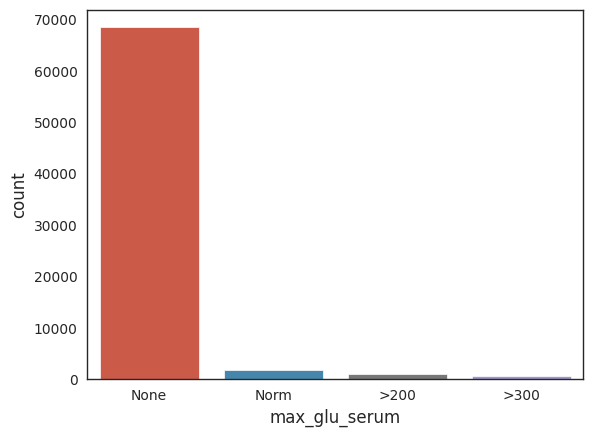

In [576]:
sns.countplot(
    data=diabetic_data,
    x='max_glu_serum',
    hue='max_glu_serum',
    order=['None', 'Norm', '>200', '>300']
)
plt.show()

#### 3.2.18 HbA1C test

Feature `A1Cresult` is used to represent the outcome of the A1c (hemoglobline) test of a patient. Let's see its distribution.

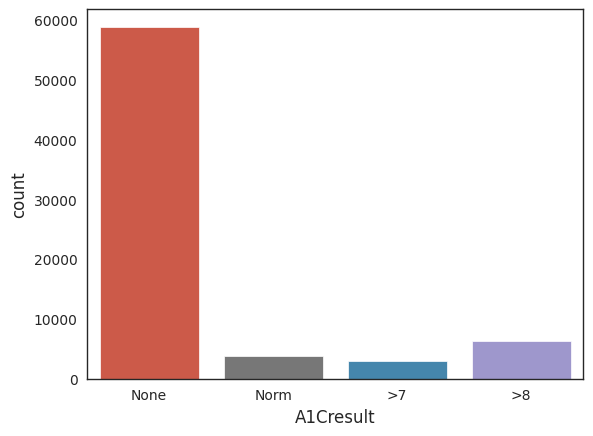

In [577]:
sns.countplot(
    data=diabetic_data,
    x='A1Cresult',
    hue='A1Cresult',
    order=['None', 'Norm', '>7', '>8']
)
plt.show()

#### 3.2.19 Diabetes medication and changes

Both `diabetes_med_change` and `diabetes_med_provided` can be seen as boolean values... so we turn them into boolean features.

In [578]:
# Making change and subministration of diabetes medication boolean
diabetic_data['diabetes_med_change'] = diabetic_data['diabetes_med_change'].replace(
    {
        'No': 0,
        'Ch': 1
    }
)
diabetic_data['diabetes_med_provided'] = diabetic_data['diabetes_med_provided'].replace(
    {
        'No': 0,
        'Yes': 1
    }
)

/tmp/ipykernel_12113/88342666.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diabetic_data['diabetes_med_change'] = diabetic_data['diabetes_med_change'].replace(
/tmp/ipykernel_12113/88342666.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diabetic_data['diabetes_med_provided'] = diabetic_data['diabetes_med_provided'].replace(


#### 3.2.20 Insulin

Let's see the distribution of values for `insulin`.

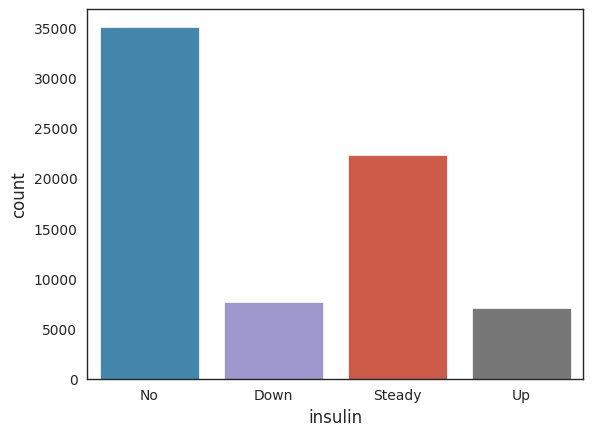

In [579]:
sns.countplot(
    data=diabetic_data,
    x='insulin',
    hue='insulin',
    order=['No', 'Down', 'Steady', 'Up']
)
plt.show()

Let's combine the variation of dosages under a unique value.

In [580]:
diabetic_data['insulin'] = diabetic_data['insulin'].map({
    'No': 'No',
    'Steady': 'Steady',
    'Down': 'Changed',
    'Up': 'Changed'
})

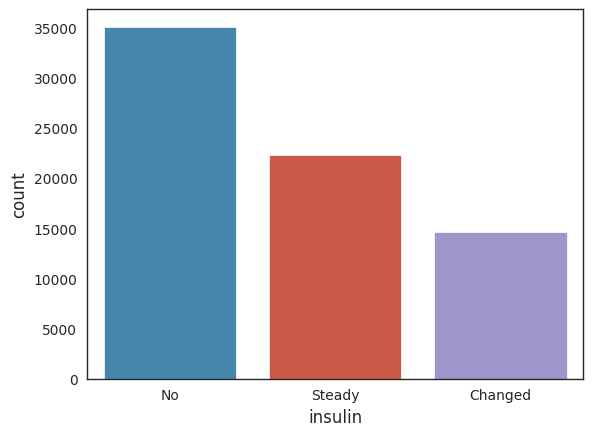

In [581]:
sns.countplot(
    data=diabetic_data,
    x='insulin',
    hue='insulin',
    order=['No', 'Steady', 'Changed']
)
plt.show()

Finally, let's create two boolean values, one for when the patient was given insulin, and the other one for when the insulin dosage was changed.

In [582]:
diabetic_data['insulin_given'] = diabetic_data['insulin'].apply(
    lambda x: 0 if x == 'No' else 1
)

diabetic_data['insulin_dose_changed'] = diabetic_data['insulin'].apply(
    lambda x: 1 if x == 'Changed' else 0
)

#### 3.2.21 Metformin

Let's see the distribution of values for `metformin`.

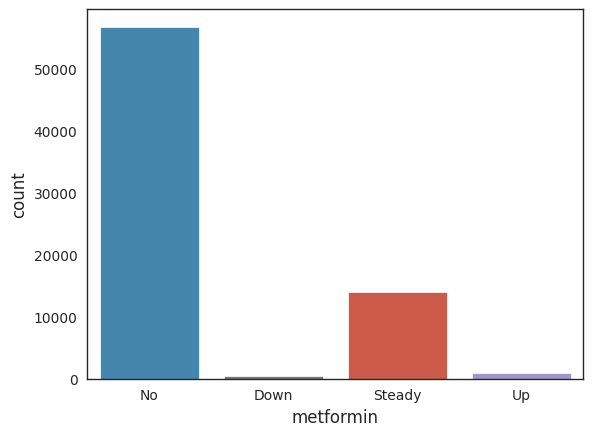

In [583]:
sns.countplot(
    data=diabetic_data,
    x='metformin',
    hue='metformin',
    order=['No', 'Down', 'Steady', 'Up']
)
plt.show()

Although it doesn't look promising, let's create a boolean feature for when metformin was given to the patient.

In [584]:
diabetic_data['metformin_given'] = diabetic_data['metformin'].apply(
    lambda x: 0 if x == 'No' else 1
)

#### 3.2.22 Medical specialties

Mapping **medical_specialty** to macro-categories.

In [585]:
diabetic_data['medical_specialty'].sort_values(ascending=True).unique()

array(['AllergyandImmunology', 'Anesthesiology',
       'Anesthesiology-Pediatric', 'Cardiology', 'Cardiology-Pediatric',
       'DCPTEAM', 'Dentistry', 'Dermatology', 'Emergency/Trauma',
       'Endocrinology', 'Endocrinology-Metabolism',
       'Family/GeneralPractice', 'Gastroenterology', 'Gynecology',
       'Hematology', 'Hematology/Oncology', 'Hospitalist',
       'InfectiousDiseases', 'InternalMedicine', 'Nephrology',
       'Neurology', 'Neurophysiology',
       'Obsterics&Gynecology-GynecologicOnco', 'Obstetrics',
       'ObstetricsandGynecology', 'Oncology', 'Ophthalmology',
       'Orthopedics', 'Orthopedics-Reconstructive', 'Osteopath',
       'Otolaryngology', 'OutreachServices', 'Pathology', 'Pediatrics',
       'Pediatrics-CriticalCare', 'Pediatrics-EmergencyMedicine',
       'Pediatrics-Endocrinology', 'Pediatrics-Hematology-Oncology',
       'Pediatrics-Neurology', 'Pediatrics-Pulmonology', 'Perinatology',
       'PhysicalMedicineandRehabilitation', 'PhysicianNotFound'

In [586]:
def map_medical_specialty(medical_specialty):
    # Handle missing values
    if pd.isnull(medical_specialty):
        return 'Missing'
    
    if medical_specialty in [
        'Family/GeneralPractice', 'InternalMedicine', 'Resident', 'Hospitalist'
    ]:
        return 'Internal Medicine'
    
    elif medical_specialty in [
        'Cardiology', 'Cardiology-Pediatric', 'Surgery-Cardiovascular',
        'Surgery-Cardiovascular/Thoracic', 'Surgery-Thoracic', 'Surgery-Vascular'
    ]:
        return 'Cardiology & Cardiovascular'
    
    elif medical_specialty in [
        'Surgery-General', 'Surgery-Pediatric', 'Surgery-Colon&Rectal',
        'Surgery-Plastic', 'Surgery-PlasticwithinHeadandNeck',
        'Surgery-Neuro', 'SurgicalSpecialty', 'Surgeon'
    ]:
        return 'Surgery'
    
    elif medical_specialty in [
        'Psychiatry', 'Psychiatry-Addictive', 'Psychiatry-Child/Adolescent', 'Psychology'
    ]:
        return 'Mental Health'
    
    elif medical_specialty in [
        'Pulmonology', 'InfectiousDiseases'
    ]:
        return 'Pulmonary $ Infectious Diseases'
    
    elif medical_specialty == 'Emergency/Trauma':
        return 'Acute & Emergency Care'
    
    else:
        return 'Other'

In [587]:
diabetic_data['medical_specialty_group'] = diabetic_data['medical_specialty'].apply(map_medical_specialty)

In [588]:
specialty_counts = get_readmission_distribution('medical_specialty_group', 'Medical Specialty Group', sort_by='Total')
specialty_counts

,Medical Specialty Group,No Readmission,Readmission,Total,Percentage
0,Missing,30424,2741,33165,0.082647
1,Internal Medicine,14930,1708,16638,0.102657
2,Other,6895,787,7682,0.102447
3,Cardiology & Cardiovascular,5105,456,5561,0.082000
4,Acute & Emergency Care,4246,375,4621,0.081151
5,Surgery,2638,256,2894,0.088459
6,Mental Health,642,88,730,0.120548
7,Pulmonary $ Infectious Diseases,622,69,691,0.099855


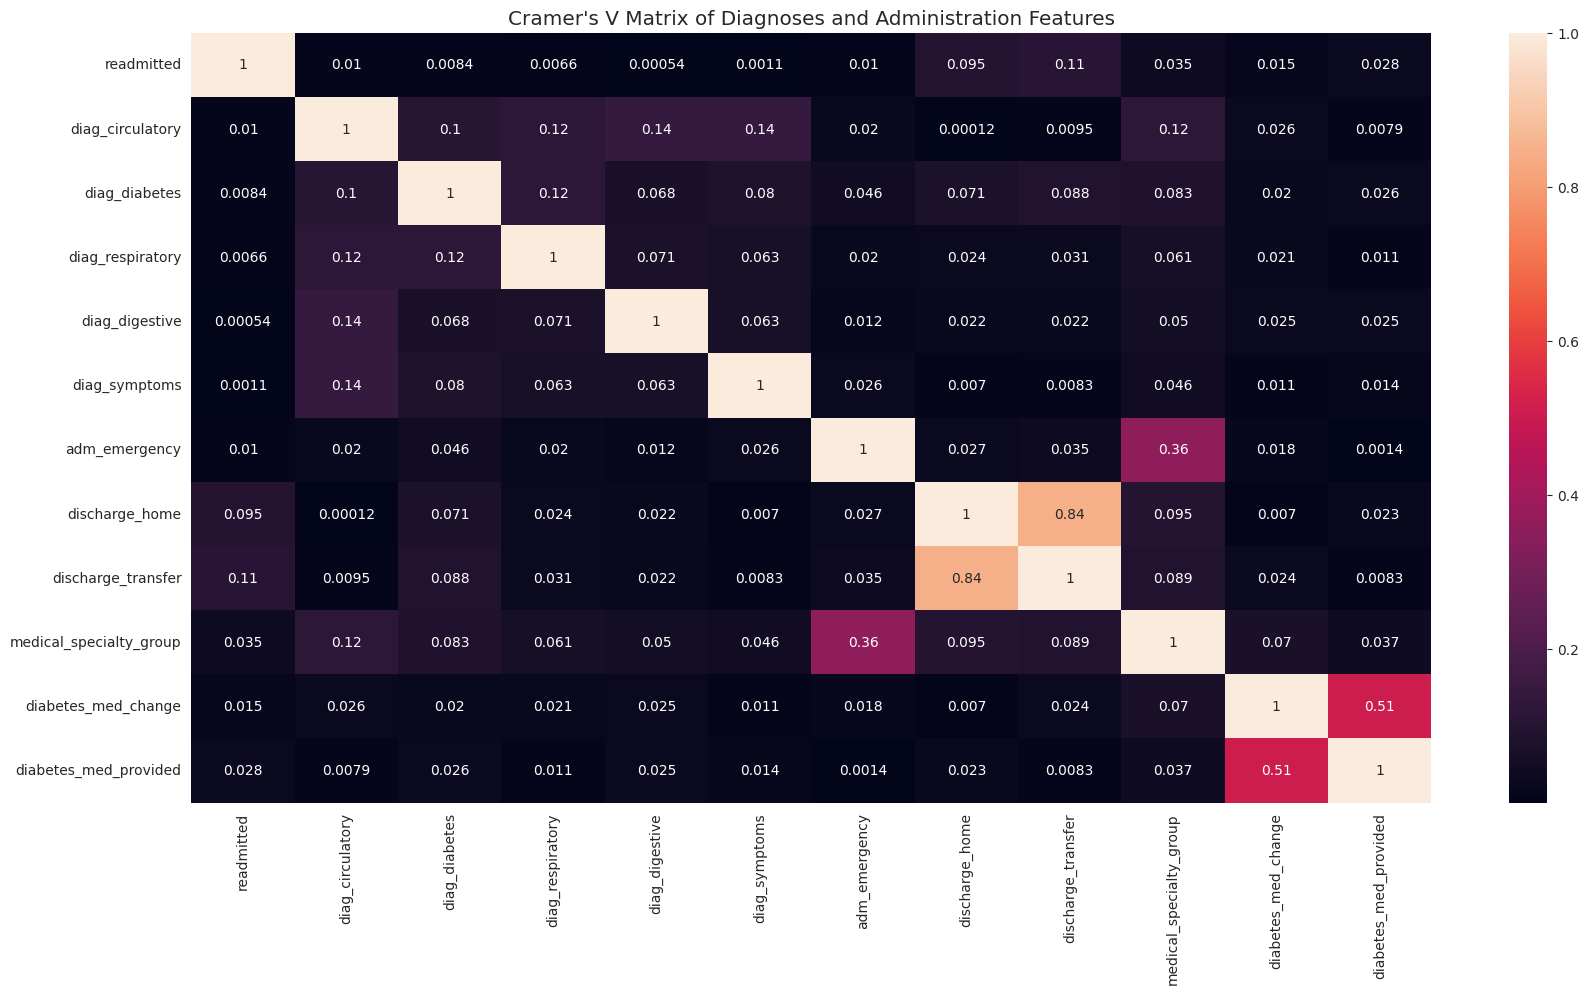

In [589]:
plt.figure(figsize=(20, 10))  # Set the figure size
cramer_matrix(
    data=diabetic_data,
    columns=[
        'readmitted',
        'diag_circulatory', 'diag_diabetes', 'diag_respiratory', 'diag_digestive', 'diag_symptoms',
        'adm_emergency', 'discharge_home', 'discharge_transfer', 'medical_specialty_group',
        'diabetes_med_change', 'diabetes_med_provided'
    ]
)
plt.title("Cramer's V Matrix of Diagnoses and Administration Features")
plt.show()

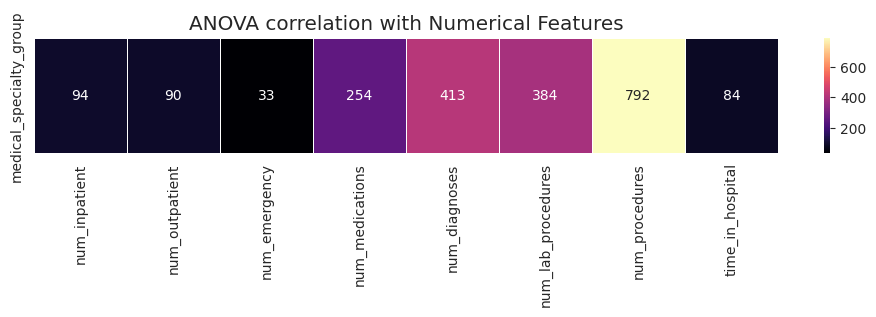

In [590]:
NUMERICAL_COLUMNS = [
    'num_inpatient', 'num_outpatient', 'num_emergency',
    'num_medications', 'num_diagnoses',
    'num_lab_procedures', 'num_procedures', 'time_in_hospital'
]

plt.figure(figsize=(12, 1.5))  # Set the figure size
anova_matrix(
    data=diabetic_data,
    categorical_cols=['medical_specialty_group'],
    numerical_cols=NUMERICAL_COLUMNS,
    linewidths=0.5,
    cmap = 'magma', fmt='.0f'
)
plt.title('ANOVA correlation with Numerical Features')
plt.show()

In [591]:
# Select the features and target
features = [
    'diag_circulatory', 'diag_diabetes', 'diag_respiratory', 'diag_digestive', 'diag_symptoms',
    'adm_emergency', 'num_medications', 'num_procedures', 'num_diagnoses'
]
target = 'medical_specialty_group'

# Set the missing values to None
diabetic_data.loc[diabetic_data[target] == 'Missing', target] = None

# Separate the data into training and prediction sets
train_data = diabetic_data[diabetic_data[target].notnull()]
predict_data = diabetic_data[diabetic_data[target].isnull()]

# Prepare the training data
X_train = train_data[features]
y_train = train_data[target]

# Prepare the prediction data
X_predict = predict_data[features]

# Train the model
model = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Predict the missing values
predictions = model.predict(X_predict)

In [592]:
# Impute the missing values in the original DataFrame
diabetic_data.loc[diabetic_data[target].isnull(), target] = predictions

In [593]:
specialty_counts = get_readmission_distribution('medical_specialty_group', 'Medical Specialty Group', sort_by='Total')
specialty_counts

,Medical Specialty Group,No Readmission,Readmission,Total,Percentage
0,Internal Medicine,38153,3833,41986,0.091292
1,Other,11467,1189,12656,0.093948
2,Cardiology & Cardiovascular,7726,669,8395,0.079690
3,Acute & Emergency Care,4254,376,4630,0.081210
4,Surgery,2638,256,2894,0.088459
5,Mental Health,642,88,730,0.120548
6,Pulmonary $ Infectious Diseases,622,69,691,0.099855


In [594]:
diabetic_data['medical_internal'] = diabetic_data['medical_specialty_group'].apply(
    lambda disch: 1 if disch == "Internal Medicine" else 0
)

diabetic_data['medical_cardio'] = diabetic_data['medical_specialty_group'].apply(
    lambda disch: 1 if disch == "Cardiology & Cardiovascular" else 0
)

diabetic_data['medical_surgery'] = diabetic_data['medical_specialty_group'].apply(
    lambda disch: 1 if disch == "Surgery" else 0
)

### 3.3 Feature Extraction
Creating new features from existing ones.

##### 3.3.1 HbA1C & diabetes medication changed

In [595]:
diabetic_data['HbA1c_none'] = diabetic_data['A1Cresult'].apply(
    lambda x: 1 if x == 'None' else 0
)

diabetic_data['HbA1c_norm'] = diabetic_data['A1Cresult'].apply(
    lambda x: 1 if x == 'Norm' else 0
)

diabetic_data['HbA1c_high_unchanged'] = diabetic_data[['A1Cresult', 'diabetes_med_change']].apply(
    lambda row: 1 if row['A1Cresult'] == '>8' and row['diabetes_med_change'] == 0 else 0,
    axis=1
)

diabetic_data['HbA1c_high_changed'] = diabetic_data[['A1Cresult', 'diabetes_med_change']].apply(
    lambda row: 1 if row['A1Cresult'] == '>8' and row['diabetes_med_change'] == 1 else 0,
    axis=1
)

In [596]:
diabetic_data['HbA1c_group'] = diabetic_data[['HbA1c_none', 'HbA1c_norm', 'HbA1c_high_unchanged', 'HbA1c_high_changed']].idxmax(axis=1)
hbA1C_group = get_readmission_distribution('HbA1c_group', 'HbA1c Group', sort_by='Total')
hbA1C_group

,HbA1c Group,No Readmission,Readmission,Total,Percentage
0,HbA1c_none,56150,5625,61775,0.091056
1,HbA1c_high_changed,3790,359,4149,0.086527
2,HbA1c_norm,3492,331,3823,0.086581
3,HbA1c_high_unchanged,2070,165,2235,0.073826


### 3.4 Data Post-Cleaning
Removing entries, based on discoveries made during the preprocessing phase.

#### 3.4.1 Dropping dangling features
Removing features that are not anymore needed.

In [597]:
diabetic_data = diabetic_data.drop(columns=[
    'patient_nbr', 'race',
    'diag_1', 'diag_2', 'diag_3', 'diag_1_group', 'diag_2_group', 'diag_3_group',
    'admission_type_id', 'admission_source_id', 'admission_source_group',
    'discharge_disposition_id', 'discharge_disposition_group',
    'medical_specialty', 'medical_specialty_group',
    'max_glu_serum', 'A1Cresult', 'HbA1c_group',
    'metformin', 'insulin'
])
diabetic_data.sample(5)

,age,gender,time_in_hospital,num_lab_procedures,num_procedures,num_medications,num_outpatient,num_emergency,num_inpatient,num_diagnoses,diabetes_med_change,diabetes_med_provided,readmitted,discharge_home,discharge_transfer,diag_circulatory,diag_diabetes,diag_respiratory,diag_digestive,diag_symptoms,adm_emergency,insulin_given,insulin_dose_changed,metformin_given,medical_internal,medical_cardio,medical_surgery,HbA1c_none,HbA1c_norm,HbA1c_high_unchanged,HbA1c_high_changed
18380,8.0,1,5.0,24,0,11,4,1,0,8,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
50084,8.0,1,4.0,30,1,25,0,0,0,9,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0
18114,8.0,1,4.0,41,0,21,0,0,0,9,1,1,0,0,1,0,0,1,1,0,1,1,1,1,1,0,0,1,0,0,0
7292,8.0,1,4.0,40,1,16,0,0,0,9,1,1,0,1,0,1,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0
16945,6.0,1,4.0,71,1,15,0,0,0,9,1,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0


#### 3.4.2 Duplicates
Looking for duplicate instances, by excluding the reference to the patient and encounter identifiers. Luckily, there are none of them.

In [598]:
duplicates = diabetic_data[diabetic_data.duplicated()]
duplicates

,age,gender,time_in_hospital,num_lab_procedures,num_procedures,num_medications,num_outpatient,num_emergency,num_inpatient,num_diagnoses,diabetes_med_change,diabetes_med_provided,readmitted,discharge_home,discharge_transfer,diag_circulatory,diag_diabetes,diag_respiratory,diag_digestive,diag_symptoms,adm_emergency,insulin_given,insulin_dose_changed,metformin_given,medical_internal,medical_cardio,medical_surgery,HbA1c_none,HbA1c_norm,HbA1c_high_unchanged,HbA1c_high_changed
3178,5.0,1,2.0,34,0,8,0,0,0,4,0,1,0,1,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,0


In [599]:
diabetic_data.drop_duplicates(inplace=True)
diabetic_data.reset_index(drop=True, inplace=True)

## **4. Data Visualization (after)**
Having a more thourough look at the relationships between features, after preprocessing.

### 4.1 Correlation / Association
Exploring the numeric correlation or association between different features.

In [600]:
NUMERICAL_COLUMNS = [
    'age',
    'num_inpatient', 'num_outpatient', 'num_emergency',
    'num_medications', 'num_diagnoses',
    'num_lab_procedures', 'num_procedures', 'time_in_hospital'
]

BINARY_COLUMNS = [
    'readmitted', 'gender',
    'diag_circulatory', 'diag_diabetes', 'diag_respiratory', 'diag_digestive', 'diag_symptoms',
    'adm_emergency', 'discharge_home', 'discharge_transfer',
    'medical_internal', 'medical_cardio', 'medical_surgery',
    'insulin_given', 'insulin_dose_changed', 'metformin_given',
    'HbA1c_none', 'HbA1c_norm', 'HbA1c_high_unchanged', 'HbA1c_high_changed',
    'diabetes_med_change', 'diabetes_med_provided',
]

#### 4.1.1 Numerical features
Above, the only numerical relation that exists with readmissions is related to the number of inpatient visits. Other features present very little or absent correlation with readmission status.

Below, correlation of numerical features with readmitted (binary), by using Point Biserial correlation.

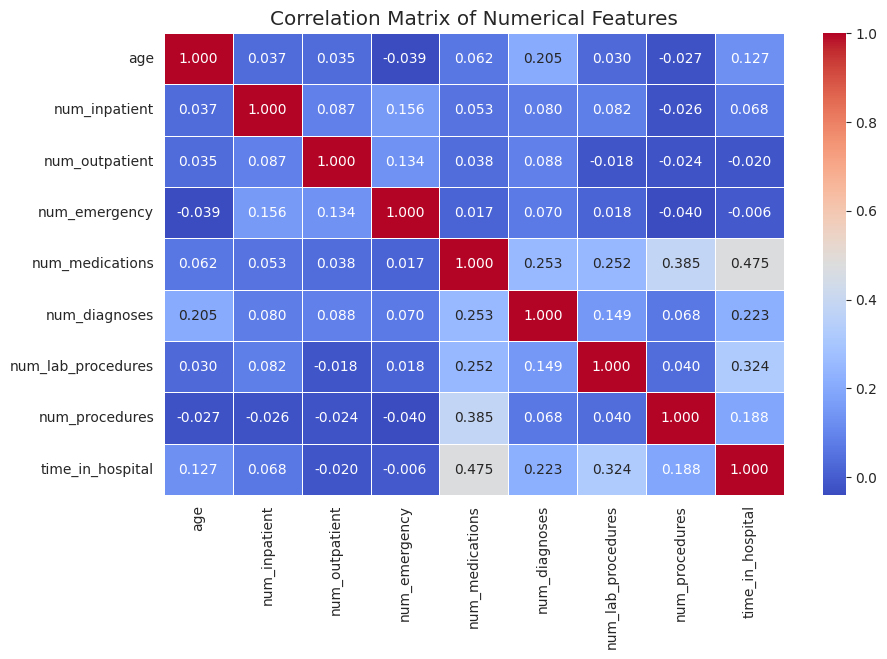

In [601]:
temp_data = diabetic_data[NUMERICAL_COLUMNS]
data_corr = temp_data.corr()

plt.figure(figsize=(10, 6))  # Set the figure size
sns.heatmap(data_corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.3f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

#### 4.1.2 Binary-numerical features

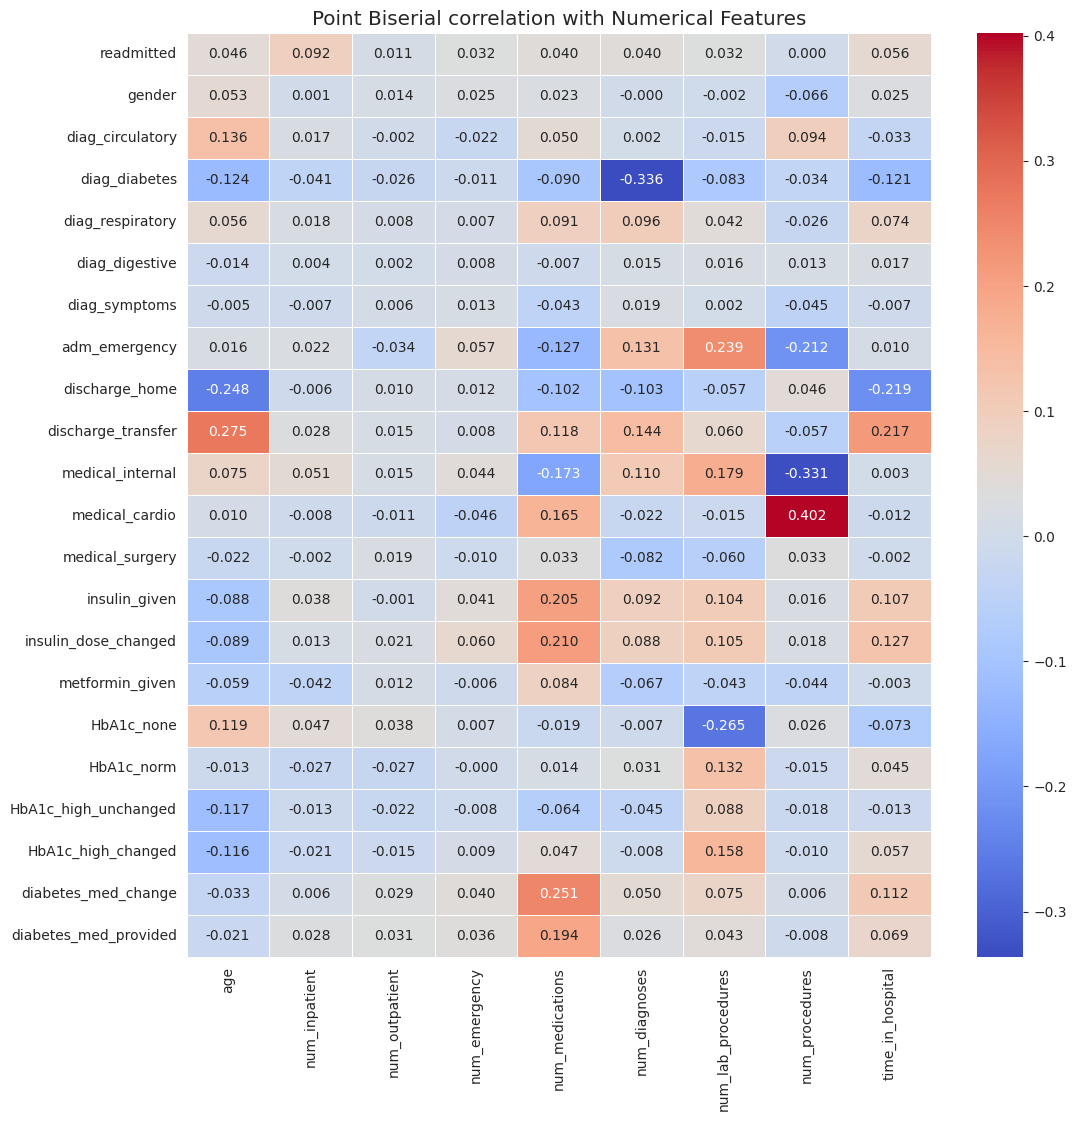

In [602]:
plt.figure(figsize=(12, 12))  # Set the figure size
point_biserial_matrix(
    data=diabetic_data,
    binary_cols=BINARY_COLUMNS,
    numerical_cols=NUMERICAL_COLUMNS,
    linewidths=0.5,
    cmap = 'coolwarm', fmt='.3f'
)
plt.title('Point Biserial correlation with Numerical Features')
plt.show()

#### 4.1.3 Binary features

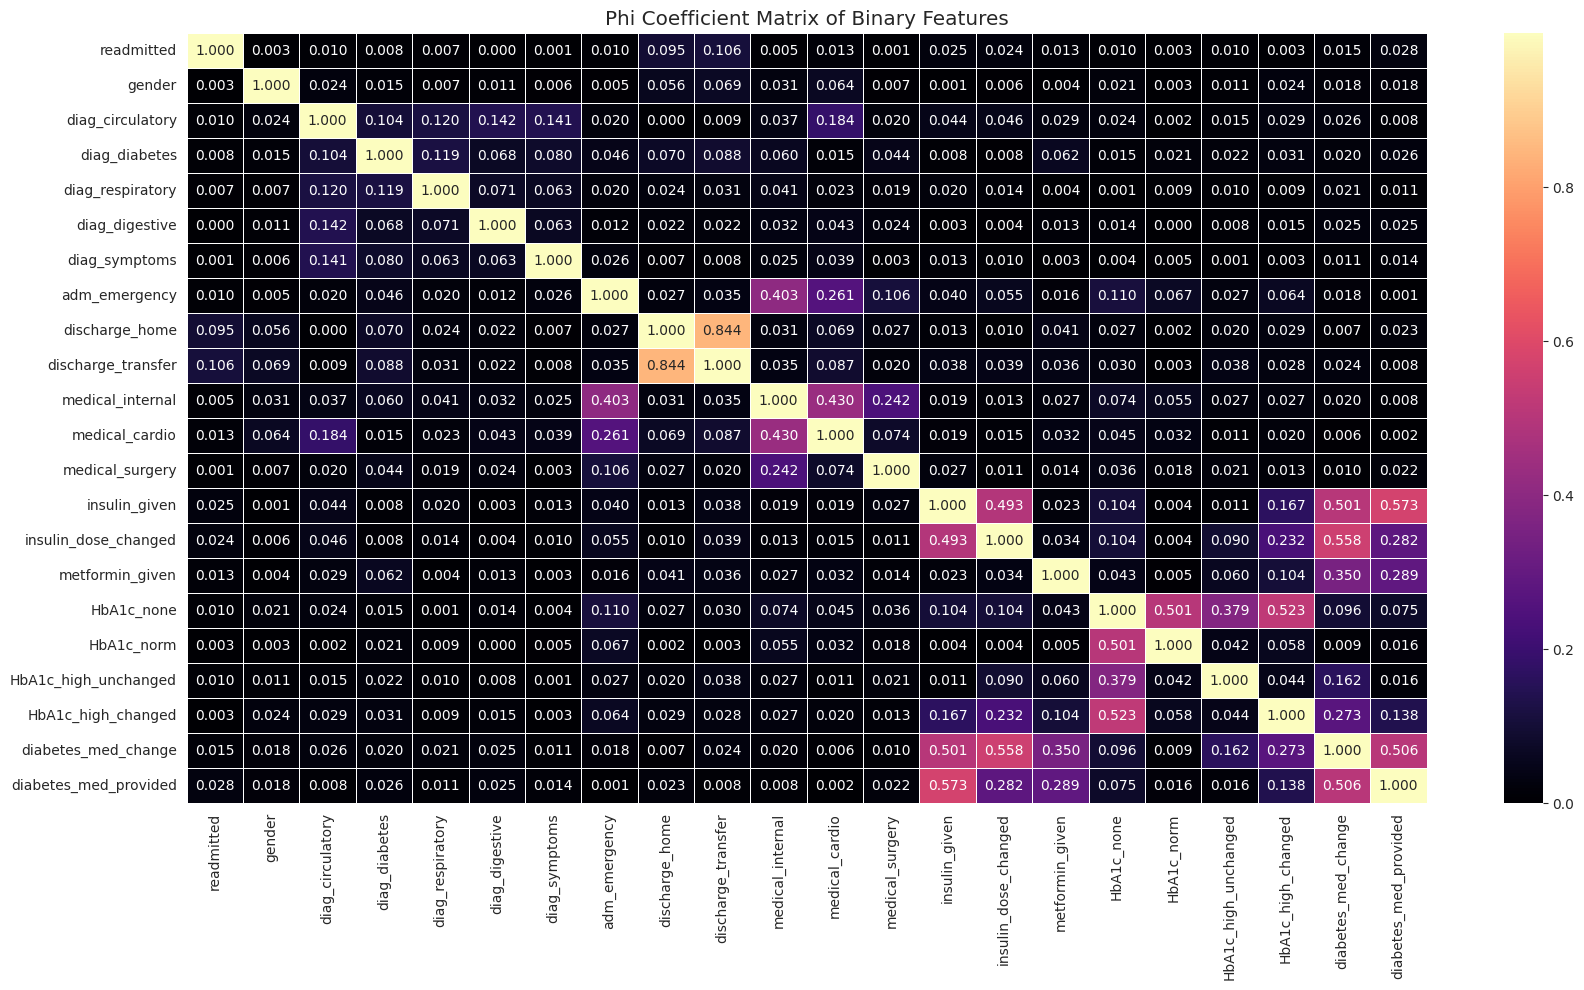

In [603]:
plt.figure(figsize=(20, 10))  # Set the figure size
phi_matrix(
    data=diabetic_data,
    binary_cols=BINARY_COLUMNS,
    linewidths=0.5,
    cmap = 'magma', fmt='.3f'
)
plt.title("Phi Coefficient Matrix of Binary Features")
plt.show()

## **5. Saving preprocessed dataset**

In [604]:
diabetic_data.sample(5)

,age,gender,time_in_hospital,num_lab_procedures,num_procedures,num_medications,num_outpatient,num_emergency,num_inpatient,num_diagnoses,diabetes_med_change,diabetes_med_provided,readmitted,discharge_home,discharge_transfer,diag_circulatory,diag_diabetes,diag_respiratory,diag_digestive,diag_symptoms,adm_emergency,insulin_given,insulin_dose_changed,metformin_given,medical_internal,medical_cardio,medical_surgery,HbA1c_none,HbA1c_norm,HbA1c_high_unchanged,HbA1c_high_changed
66732,8.0,0,5.0,51,1,16,0,0,0,9,0,1,1,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
62074,8.0,1,8.0,49,0,22,1,2,0,9,1,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0
60149,8.0,1,6.0,67,0,14,3,0,0,9,0,1,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0
18517,7.0,0,2.0,3,0,8,1,0,0,7,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0
54385,5.0,1,3.0,33,3,15,0,0,0,6,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0


In [605]:
# TODO: Save the cleaned data
diabetic_data.to_csv(
    DATA_PATH_PROCESSED + 'diabetic_data_cleaned.csv',
    index=False
)